# Single cell RNAseq analysis human TILs

## Initialisation and reading data

In [1]:
import numpy as np                                # scientific computing toolkit
import pandas as pd                               # data analysis toolkit
import scanpy as sc                               # scanpy is referred to with sc.***
import scvelo as scv                              # RNA velocity toolkit
import matplotlib.pyplot as plt                   # Matplotlib is referred to with plt.***
from scipy import stats                           # for linear regressions
import seaborn as sns                             # for easy heatmaps
import scirpy as ir                               # TCR analysis

sc.settings.verbosity = 0                         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()                       # check if all needed versions are installed and up to date
results_file = './write/results.h5ad'             # the file that will store the analysis results

scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.19.5 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.6 leidenalg==0.8.3 pynndescent==0.5.2


In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=200, color_map='viridis')

In [3]:
adata = sc.read_10x_mtx(
    "./GEX/outs/filtered_feature_bc_matrix/",
    var_names='gene_symbols',               
    cache=True, gex_only=False)                         
adata.var_names_make_unique()

In [4]:
adata_GEX=adata[:,adata.var.feature_types=='Gene Expression'].copy()
adata_SP=adata[:,adata.var.feature_types!='Gene Expression'].copy()
adata_ADT=adata_SP[:,adata_SP.var.gene_ids.str.contains('C')].copy()
adata_HTO=adata_SP[:,~adata_SP.var.gene_ids.str.contains('C')].copy()

In [5]:
adata=adata_GEX.copy()

## Demultiplex samples according to HTO antibodies

In [6]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


... storing 'Classification' as categorical
... storing 'feature_types' as categorical


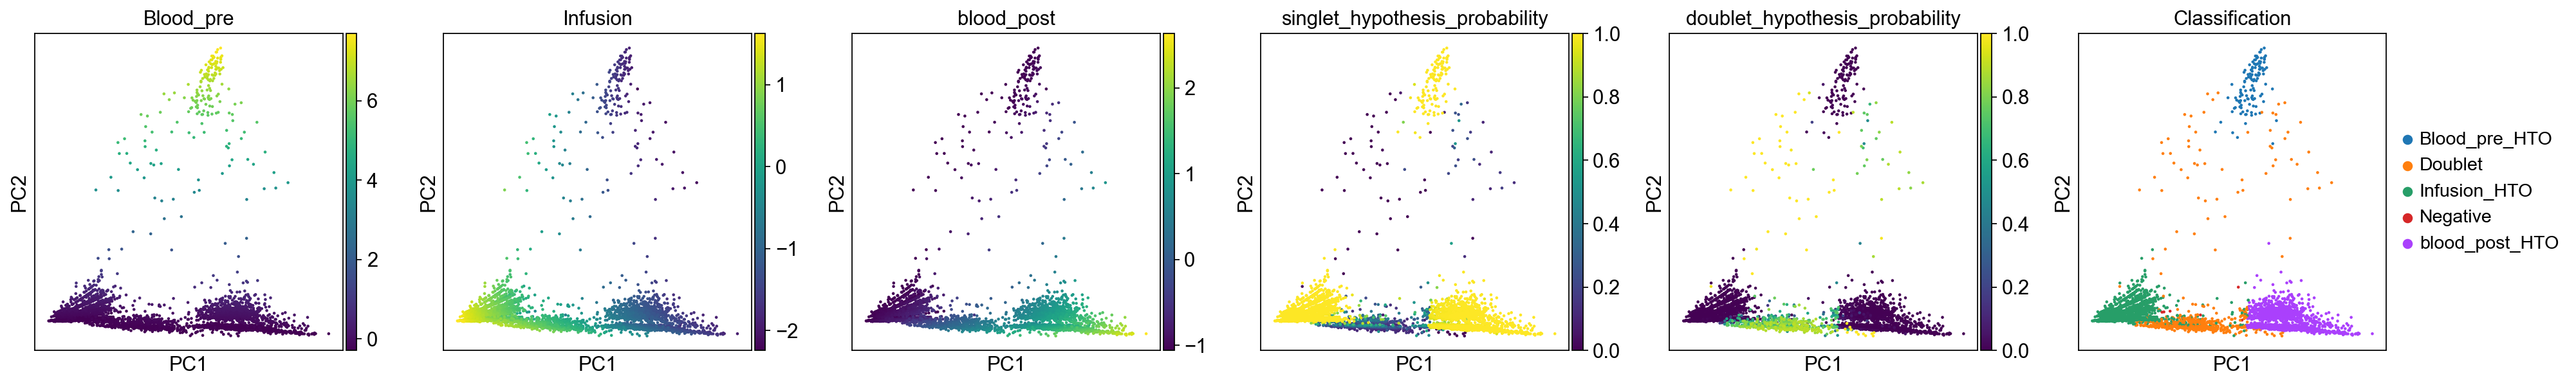

In [7]:
HTO_data=adata_HTO.copy()
HTO_data.layers["counts"] = HTO_data.X.copy()
HTO_counts=pd.DataFrame(HTO_data.X.todense(), columns=HTO_data.var_names+'_HTO', index=HTO_data.obs_names)
HTO_data.obs=pd.concat([HTO_data.obs,HTO_counts], axis=1)
sc.external.pp.hashsolo(HTO_data,cell_hashing_columns=HTO_data.obs.columns)
clr_normalize_each_cell(HTO_data)
sc.pp.log1p(HTO_data)
sc.pp.scale(HTO_data)
sc.pp.pca(HTO_data)
sc.pp.neighbors(HTO_data, n_neighbors=50)
#sc.tl.leiden(HTO_data, key_added="HTO_leiden", resolution=.1)
sc.tl.umap(HTO_data)
sc.tl.tsne(HTO_data)


#sc.pl.umap(HTO_data, color=HTO_data.var_names.tolist()+['singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification','HTO_leiden'], ncols=10, save='_HTO.pdf')
#sc.pl.tsne(HTO_data, color=HTO_data.var_names.tolist()+['singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification','HTO_leiden'], ncols=10, save='_HTO.pdf')
sc.pl.pca(HTO_data, color=HTO_data.var_names.tolist()+['singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'], ncols=10, save='_HTO.pdf')

In [8]:
print('Barcoding efficacy: '+str((HTO_data[HTO_data.obs.Classification.isin((HTO_data.var_names+'_HTO').tolist())].shape[0]/HTO_data.shape[0])*100)[:4]+' %')
print('Cellnumber Infusion product: '+str(HTO_data[HTO_data.obs.Classification=='Infusion_HTO'].shape[0]))
print('Cellnumber Blood before: '+str(HTO_data[HTO_data.obs.Classification=='Blood_pre_HTO'].shape[0]))
print('Cellnumber Blood after: '+str(HTO_data[HTO_data.obs.Classification=='blood_post_HTO'].shape[0]))

Barcoding efficacy: 90.3 %
Cellnumber Infusion product: 3431
Cellnumber Blood before: 121
Cellnumber Blood after: 2806


In [9]:
adata.obs['samplename']='None'
adata.obs.samplename[adata.obs_names.isin(HTO_data[HTO_data.obs.Classification=='Infusion_HTO'].obs_names.tolist())]='Infusion_product'
adata.obs.samplename[adata.obs_names.isin(HTO_data[HTO_data.obs.Classification=='Blood_pre_HTO'].obs_names.tolist())]='Blood_before'
adata.obs.samplename[adata.obs_names.isin(HTO_data[HTO_data.obs.Classification=='blood_post_HTO'].obs_names.tolist())]='Blood_after'

adata=adata[adata.obs.samplename!='None'].copy()

## Preprocessing

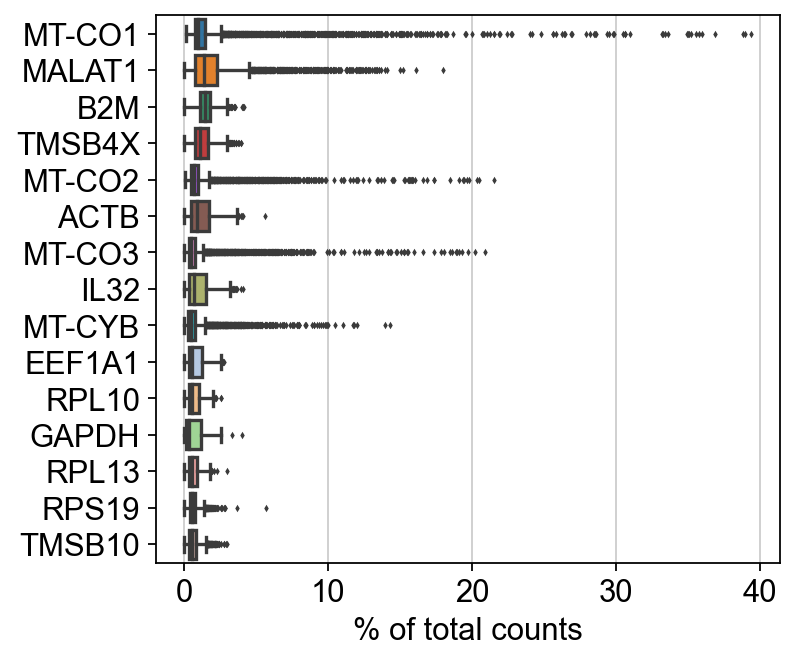

In [10]:
sc.pl.highest_expr_genes(adata, n_top=15)

Filter cells with less than 200 genes and genes that are present in less than 3 cells

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [12]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

ribo_genes = ((adata.var_names.str.startswith("RPL")) | (adata.var_names.str.startswith("RPS"))| (adata.var_names.str.startswith("MPL")))
adata.obs['percent_ribo'] = np.sum(
adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.var['ribo'] = ribo_genes

... storing 'samplename' as categorical
... storing 'feature_types' as categorical


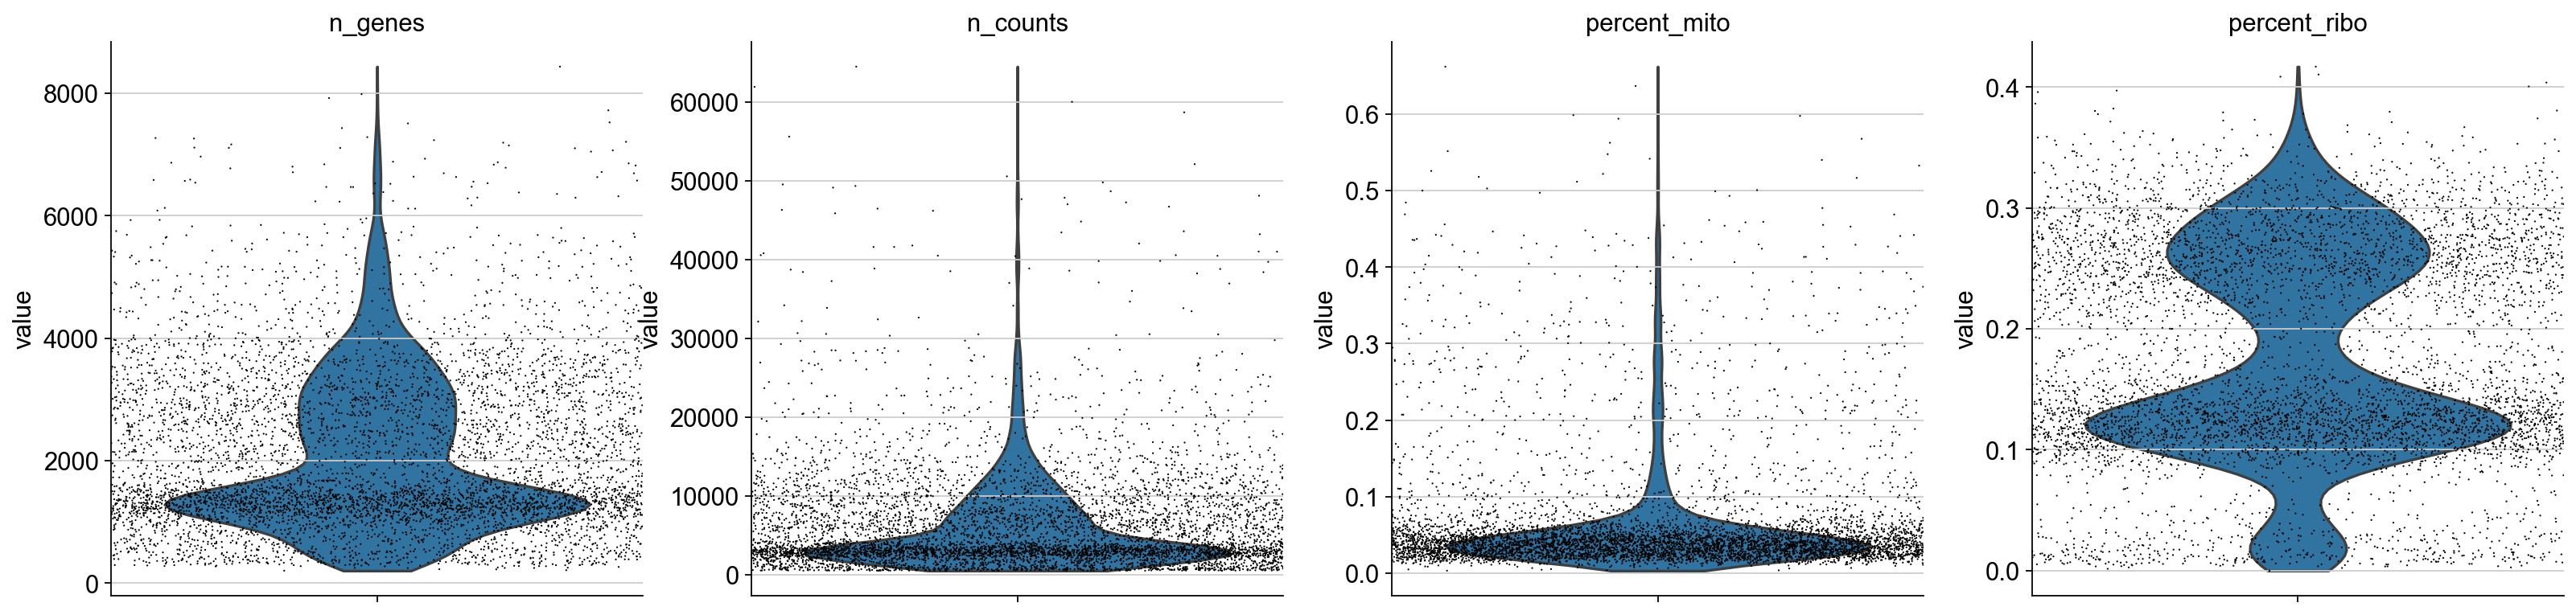

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
             jitter=0.5, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts. First, plot the counts versus the percentage of mitochondrial genes and versus the number of genes to define a threshold for later filtering.

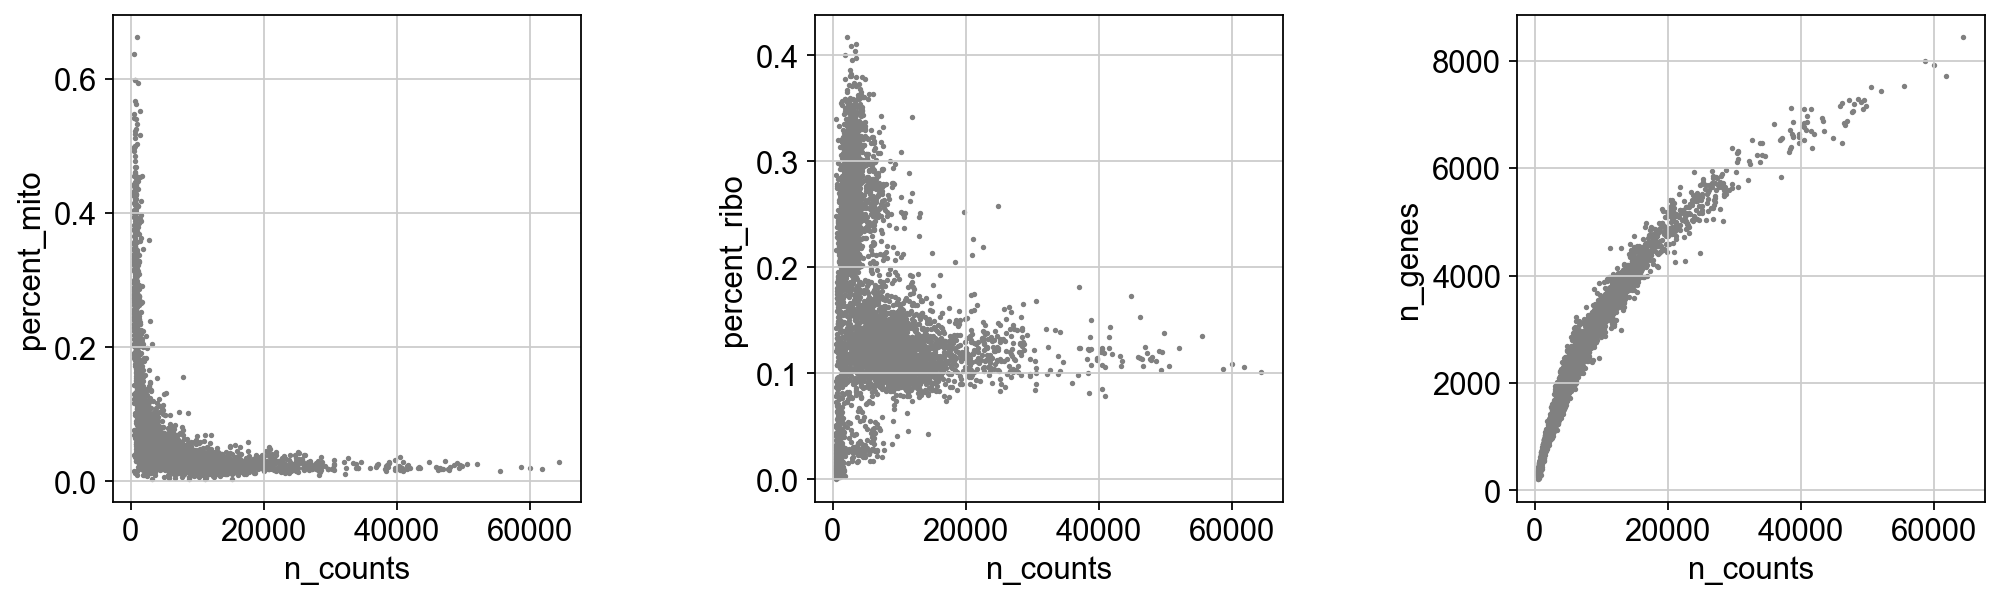

In [14]:
counts = adata.obs['n_counts']
mito = adata.obs['percent_mito']
genes = adata.obs['n_genes']
ribo = adata.obs['percent_ribo']
fig = plt.figure(figsize=(15, 4))
grid = plt.GridSpec(1, 3, hspace=0, wspace=0.5)
percent_mito = fig.add_subplot(grid[0, 0], xlabel='n_counts', ylabel='percent_mito')
percent_ribo = fig.add_subplot(grid[0, 1], xlabel='n_counts', ylabel='percent_ribo')
n_genes = fig.add_subplot(grid[0, 2], xlabel='n_counts', ylabel='n_genes')
percent_mito.scatter(counts, mito, s=2, c='gray')
percent_ribo.scatter(counts, ribo, s=2, c='gray')
n_genes.scatter(counts, genes, s=2, c='gray')

In [15]:
counts_before=adata.n_obs
adata = adata[adata.obs['n_genes'] < 7000, :]
adata = adata[adata.obs['n_counts'] < 50000, :]
adata = adata[adata.obs['percent_mito'] < 0.2, :]

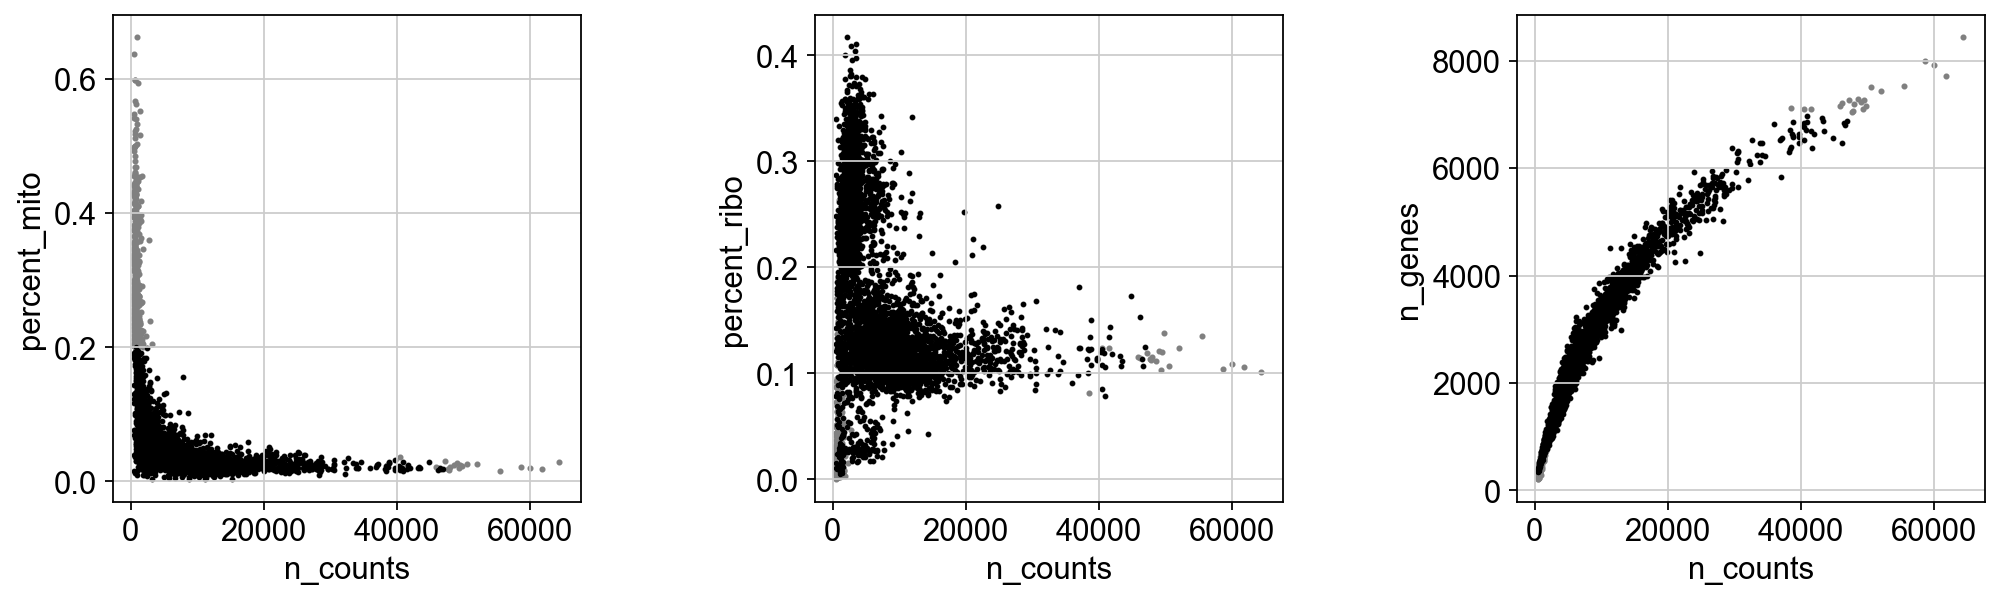

In [16]:
counts2 = adata.obs['n_counts']
mito2 = adata.obs['percent_mito']
genes2 = adata.obs['n_genes']
ribo2 = adata.obs['percent_ribo']

fig = plt.figure(figsize=(15, 4))
grid = plt.GridSpec(1, 3, hspace=0, wspace=0.5)
percent_mito = fig.add_subplot(grid[0, 0], xlabel='n_counts', ylabel='percent_mito')
percent_ribo = fig.add_subplot(grid[0, 1], xlabel='n_counts', ylabel='percent_ribo')
n_genes = fig.add_subplot(grid[0, 2], xlabel='n_counts', ylabel='n_genes')

percent_mito.scatter(counts, mito, s=3, c='gray')
percent_ribo.scatter(counts, ribo, s=3, c='gray')
n_genes.scatter(counts, genes, s=3, c='gray')
percent_mito.scatter(counts2, mito2, s=2, c='black')
percent_ribo.scatter(counts2, ribo2, s=2, c='black')
n_genes.scatter(counts2, genes2, s=2, c='black')

fig.savefig('./figures/filtering.pdf', dpi=2000)

In [17]:
print(str(counts_before)+' --> '+str(adata.n_obs))

6318 --> 5873


In [18]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

Trying to set attribute `.obs` of view, copying.


In [19]:
exhaustion_genes=['HAVCR2','PDCD1','LAG3','EOMES','CD101','CD38','TIGIT']
sc.tl.score_genes(adata, exhaustion_genes, score_name='exhaustion_score')

activation_genes=['TNFRSF9','IFNG','TNF','GZMB','PRF1','NKG7','XCL1','XCL2','CCL3','CCL4','CCL5','CST7','STAT1','TGFB1']
sc.tl.score_genes(adata, activation_genes, score_name='activation_score')

naive_like_state_genes=['TCF7','CCR7','SELL','LEF1','IL7R']
predysfunctional_state_genes=['EOMES', 'GZMK', 'CXCR3']
dysfunctional_state_genes=['LAG3', 'PDCD1', 'LAYN', 'HAVCR2','CTLA4']
cytotoxic_state_genes=['KLRG1','PRF1','FCGR3A','CX3CR1']
cytotoxic_activation=['CCL5', 'GZMK', 'GNLY', 'EOMES', 'ZNF683','KLRG1', 'NKG7', 'ZEB2']
cytokine_activation=['CCL3', 'IFNG', 'CCL4', 'XCL1', 'XCL2', 'CSF2', 'IL10', 'HOPX', 'TIM3', 'LAG3', 'PRF1', 'TNFRSF9', 'NKG7', 'IL26']
sc.tl.score_genes(adata, naive_like_state_genes, score_name='naive_like_state')
sc.tl.score_genes(adata, predysfunctional_state_genes, score_name='predysfunctional_state')
sc.tl.score_genes(adata, dysfunctional_state_genes, score_name='dysfunctional_state')
sc.tl.score_genes(adata, cytotoxic_state_genes, score_name='cytotoxic_state')
sc.tl.score_genes(adata, dysfunctional_state_genes, score_name='cytotoxic_activation')
sc.tl.score_genes(adata, cytotoxic_state_genes, score_name='cytokine_activation')

## Cell cycle scoring

... storing 'phase' as categorical


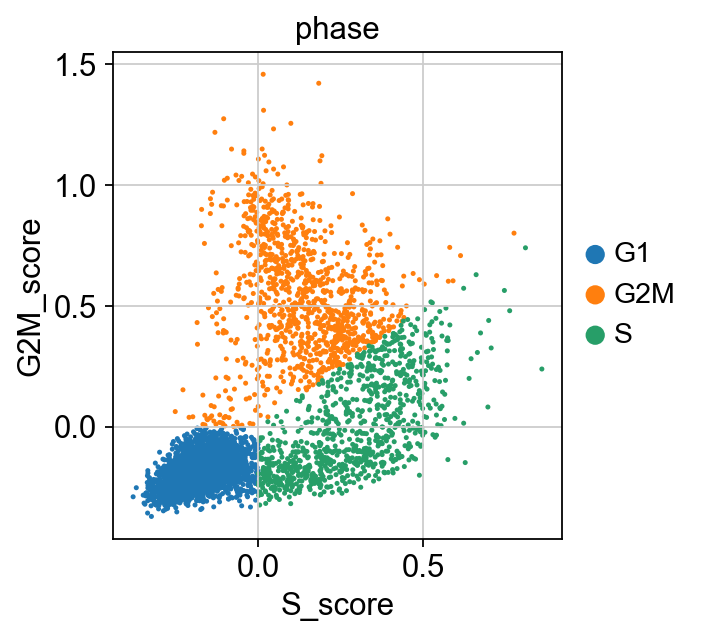

In [20]:
cc_genes=pd.read_csv("./analysis_info/regev_lab_cell_cycle_genes.txt")
s_genes=cc_genes[:46]
g2m_genes=cc_genes[47:]
s_genes.columns=['genes']
g2m_genes.columns=['genes']
sc.tl.score_genes_cell_cycle(adata, s_genes.genes, g2m_genes.genes)
sc.pl.scatter(adata, x='S_score', y='G2M_score', color='phase')

In [21]:
adata.raw = adata

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

In [23]:
# Remove TCR chains for clustering analysis
adata=adata[:,adata.var_names[~np.logical_or(adata.var_names.str.contains('TRB'),
                               adata.var_names.str.contains('TRA'))]]

## Principal component analysis and neighborhood graph

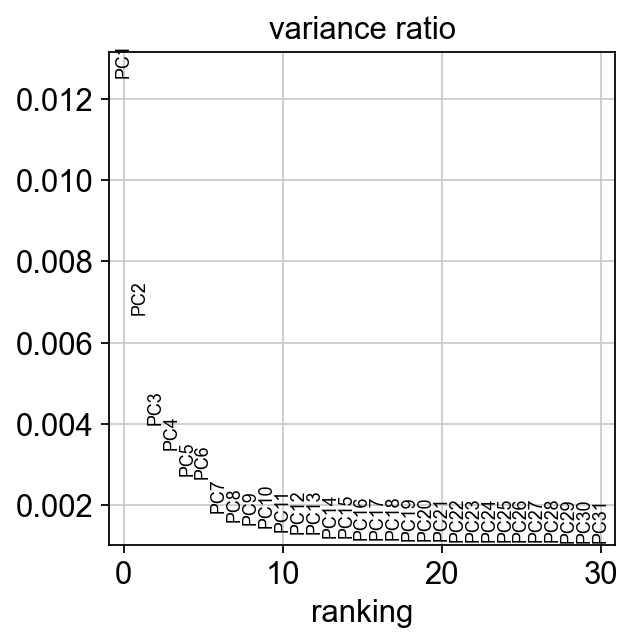

In [24]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

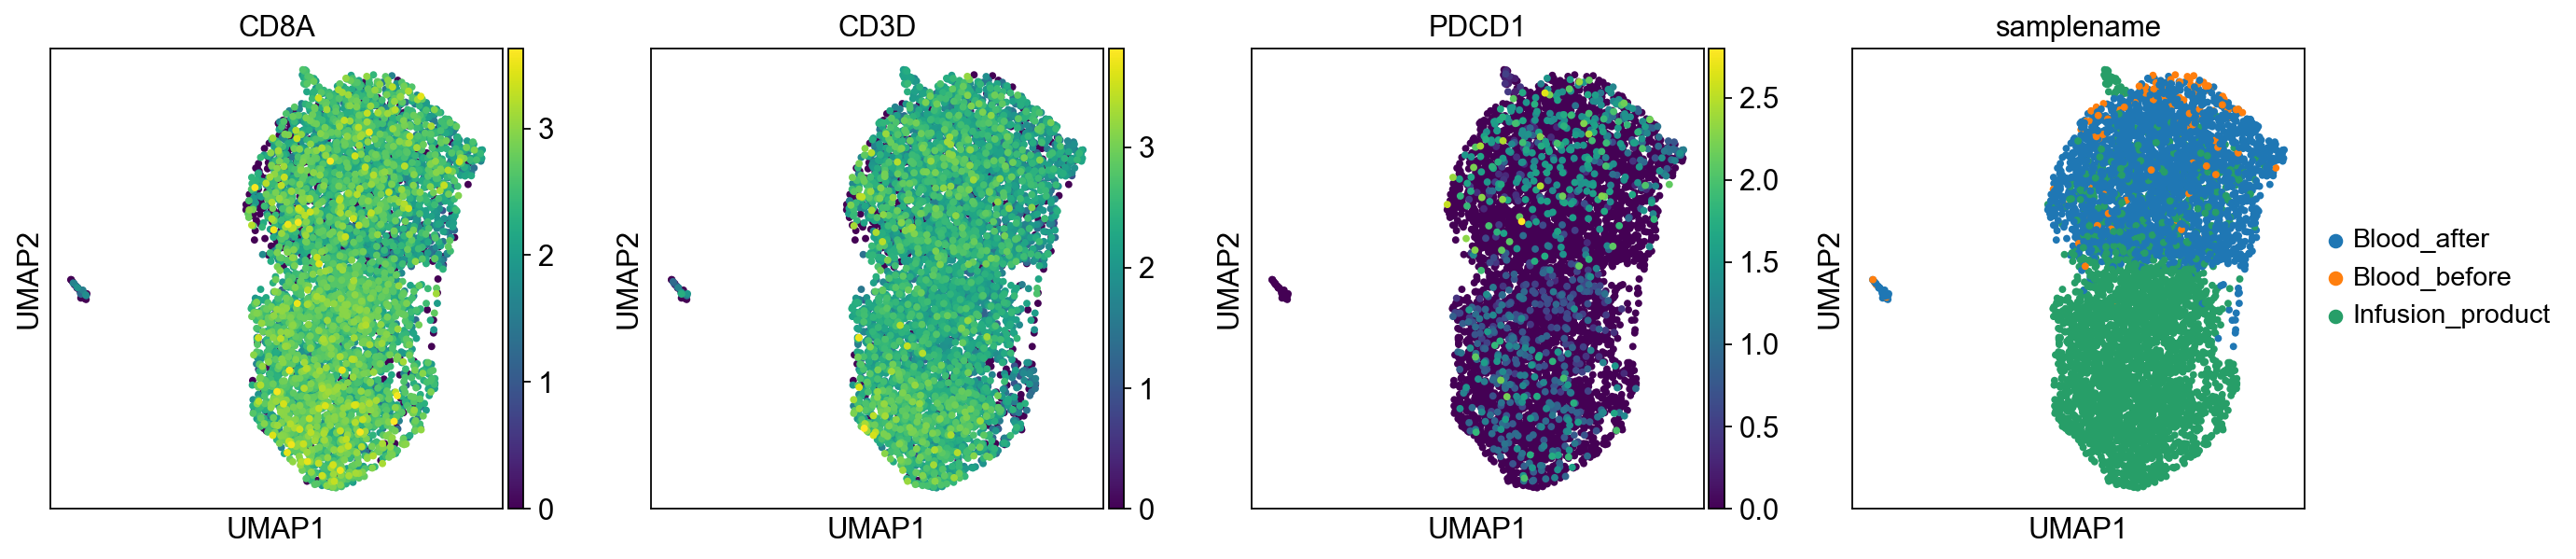

In [25]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=6)
sc.tl.umap(adata, min_dist=0.7)
sc.pl.umap(adata, color=['CD8A', 'CD3D','PDCD1','samplename'],s=50)

## Clustering the neighborhood graph

In [26]:
from sklearn.metrics import silhouette_score
def titrate_leiden_resolution(adata):
    res_array=list(np.round(np.linspace(.1, 2, 20),1))
    silhoutte_list=list()
    sc.settings.verbosity = 1
    for i,res in enumerate(res_array):
        sc.tl.leiden(adata, resolution=res)
        if adata.obs.leiden.unique().shape[0]>2:
            silhoutte_list.append(silhouette_score(adata.obsm['X_umap'],
                    adata.obs[f'leiden'],
                    metric='euclidean'))
        else:
            silhoutte_list.append(np.nan)
        print(str(np.round(((i+1)/len(res_array))*100,1))+"%", end="\r", flush=True)
    sns.lineplot(res_array, silhoutte_list, color='black', markers='o')

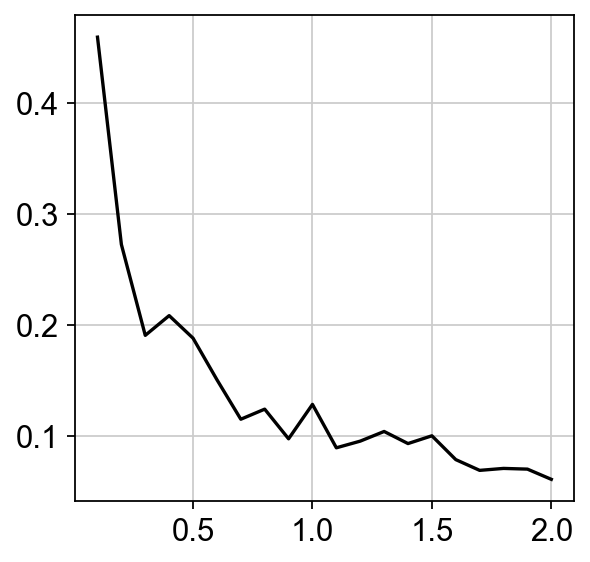

In [27]:
titrate_leiden_resolution(adata)

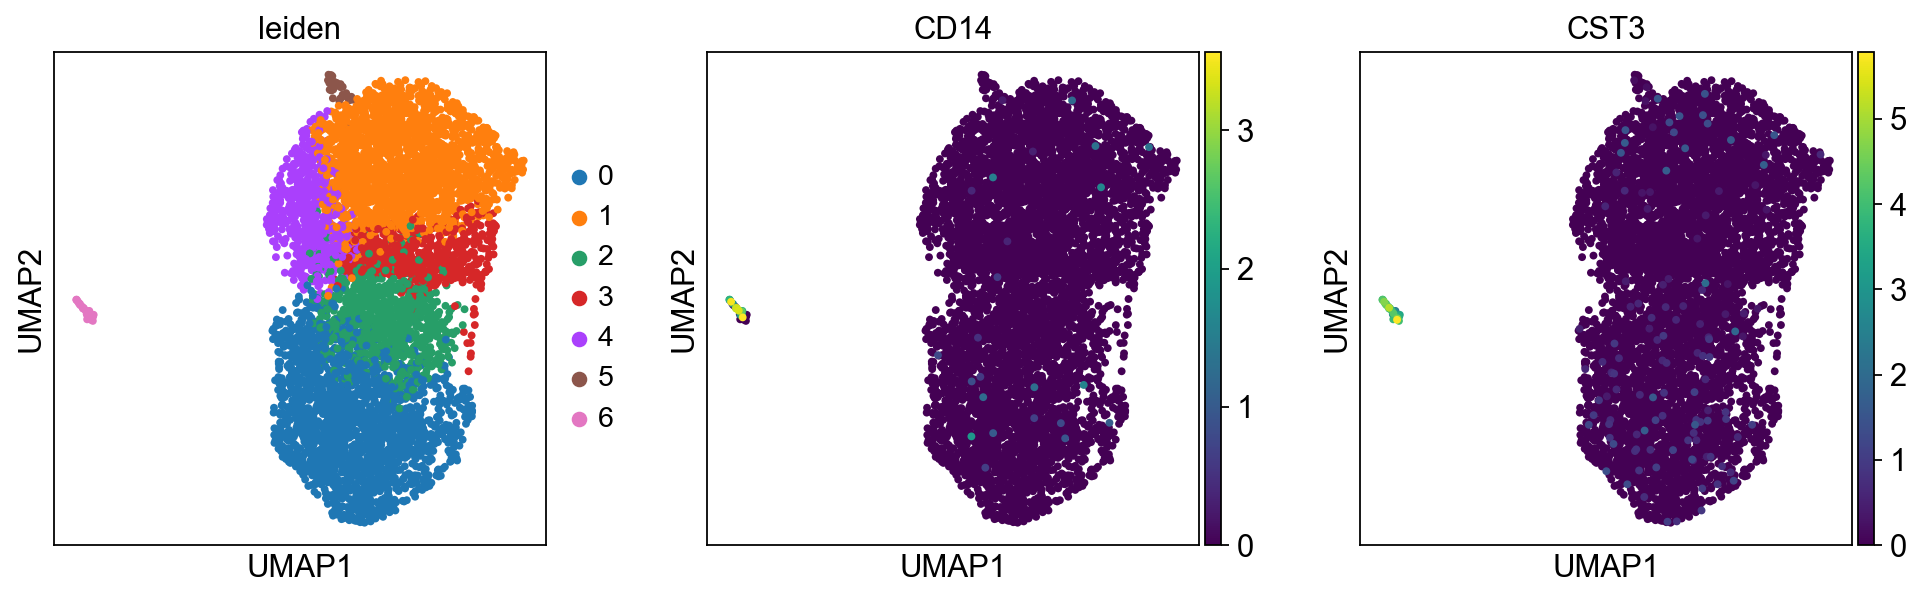

In [28]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=['leiden','CD14','CST3'], save='_leiden.pdf', s=50)

{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

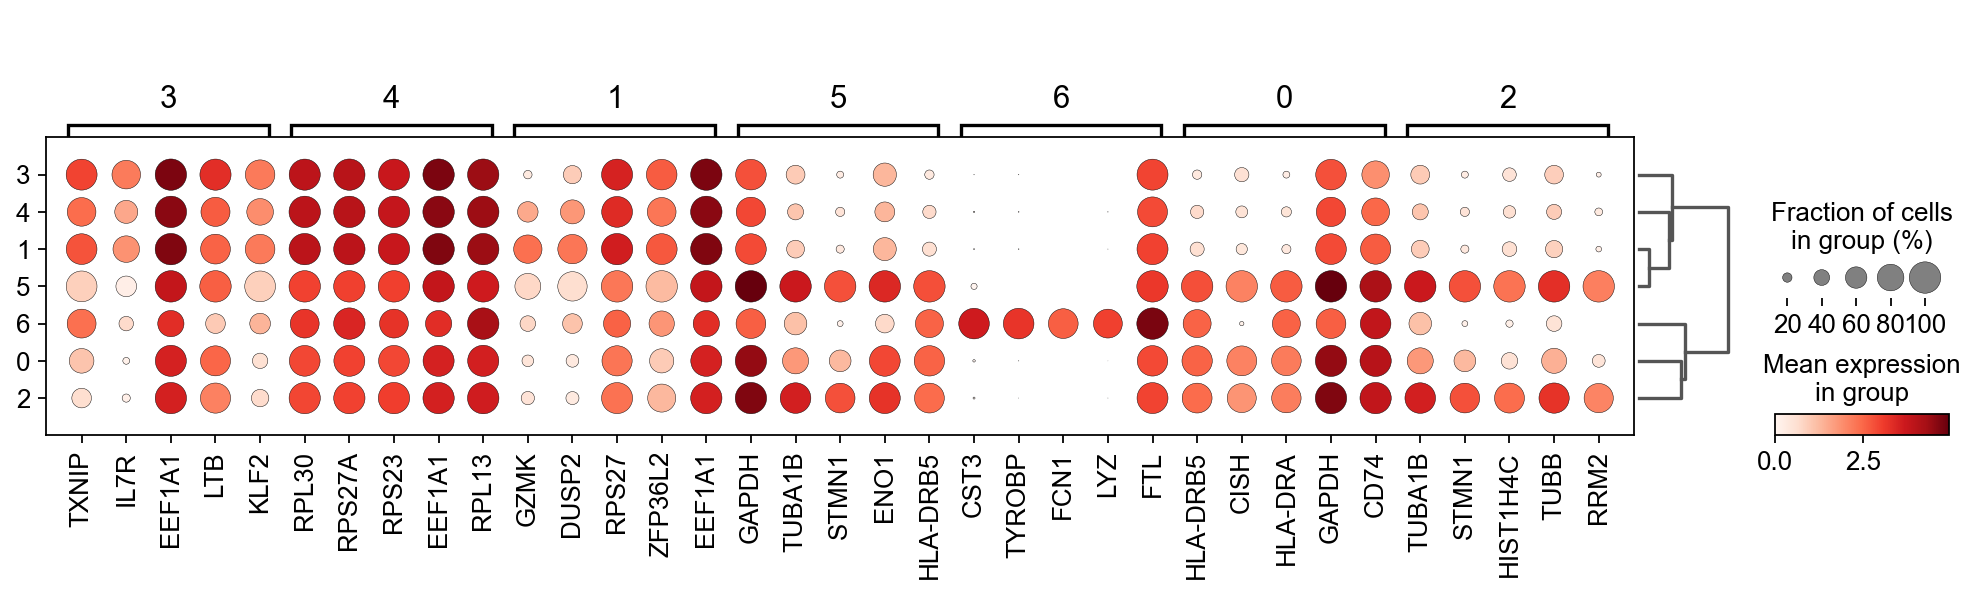

In [29]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.tl.rank_genes_groups(adata, 'leiden', use_raw=True, method='t-test')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, show=False)

# Integration of CiteSeq-Data

In [30]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

ADT_data=adata_ADT.copy()

In [31]:
clr_normalize_each_cell(ADT_data)
sc.pp.log1p(ADT_data)
sc.pp.scale(ADT_data)

In [32]:
ADT_counts=pd.DataFrame(ADT_data.X, columns=[x[:-2]+'_SP' if ('-1' in x)&('control' not in x) else x+'_SP' for x in adata_ADT.var_names], index=adata_ADT.obs_names)

In [33]:
ADT_counts=ADT_counts[ADT_counts.index.isin(adata.obs_names)]

In [34]:
adata.obs.loc[:,ADT_counts.columns]=ADT_counts

# TCR analysis scirpy

In [35]:
adata_TCR=ir.io.read_10x_vdj('./VDJ/outs/all_contig_annotations.json')

In [36]:
ir.pp.merge_with_tcr(adata, adata_TCR)

... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


<AxesSubplot:title={'center':'Number of cells in samplename by chain_pairing'}, xlabel='samplename', ylabel='Number of cells'>

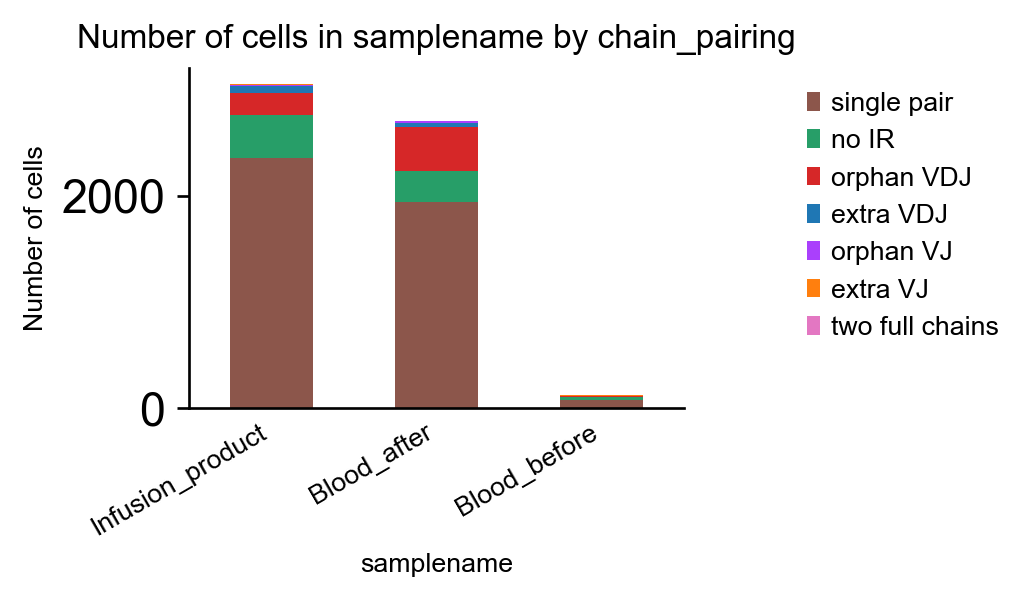

In [37]:
ir.tl.chain_pairing(adata)
ir.pl.group_abundance(adata, groupby="samplename", target_col="chain_pairing")

<AxesSubplot:title={'center':'has_ir'}, xlabel='UMAP1', ylabel='UMAP2'>

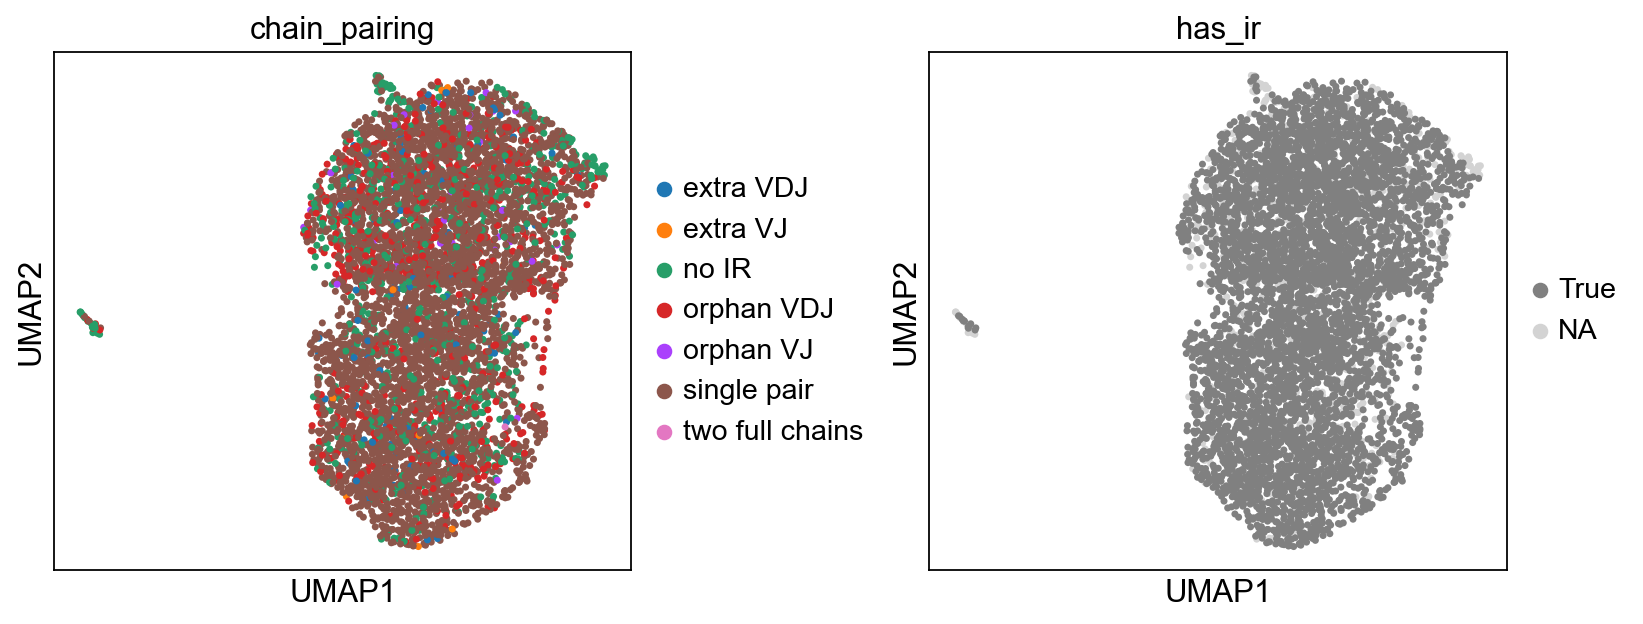

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
fig.tight_layout(w_pad=7)
sc.pl.umap(adata, color="chain_pairing", ax=ax[0], show=False, s=40, groups=adata.obs.chain_pairing[adata.obs.chain_pairing!='No TCR'].unique().tolist())
sc.pl.umap(adata, color="has_ir", palette=['gray','red'], ax=ax[1], show=False, s=40, groups="True")

In [39]:
print('Unique CDR3 alpha: '+str(adata.obs.IR_VJ_1_junction.append(adata.obs.IR_VJ_2_junction).nunique()))
print('Unique CDR3 beta: '+str(adata.obs.IR_VDJ_1_junction.append(adata.obs.IR_VDJ_2_junction).nunique()))

Unique CDR3 alpha: 137
Unique CDR3 beta: 142


In [40]:
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="all")

100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 311.71it/s]


... storing 'clone_id' as categorical


<AxesSubplot:>

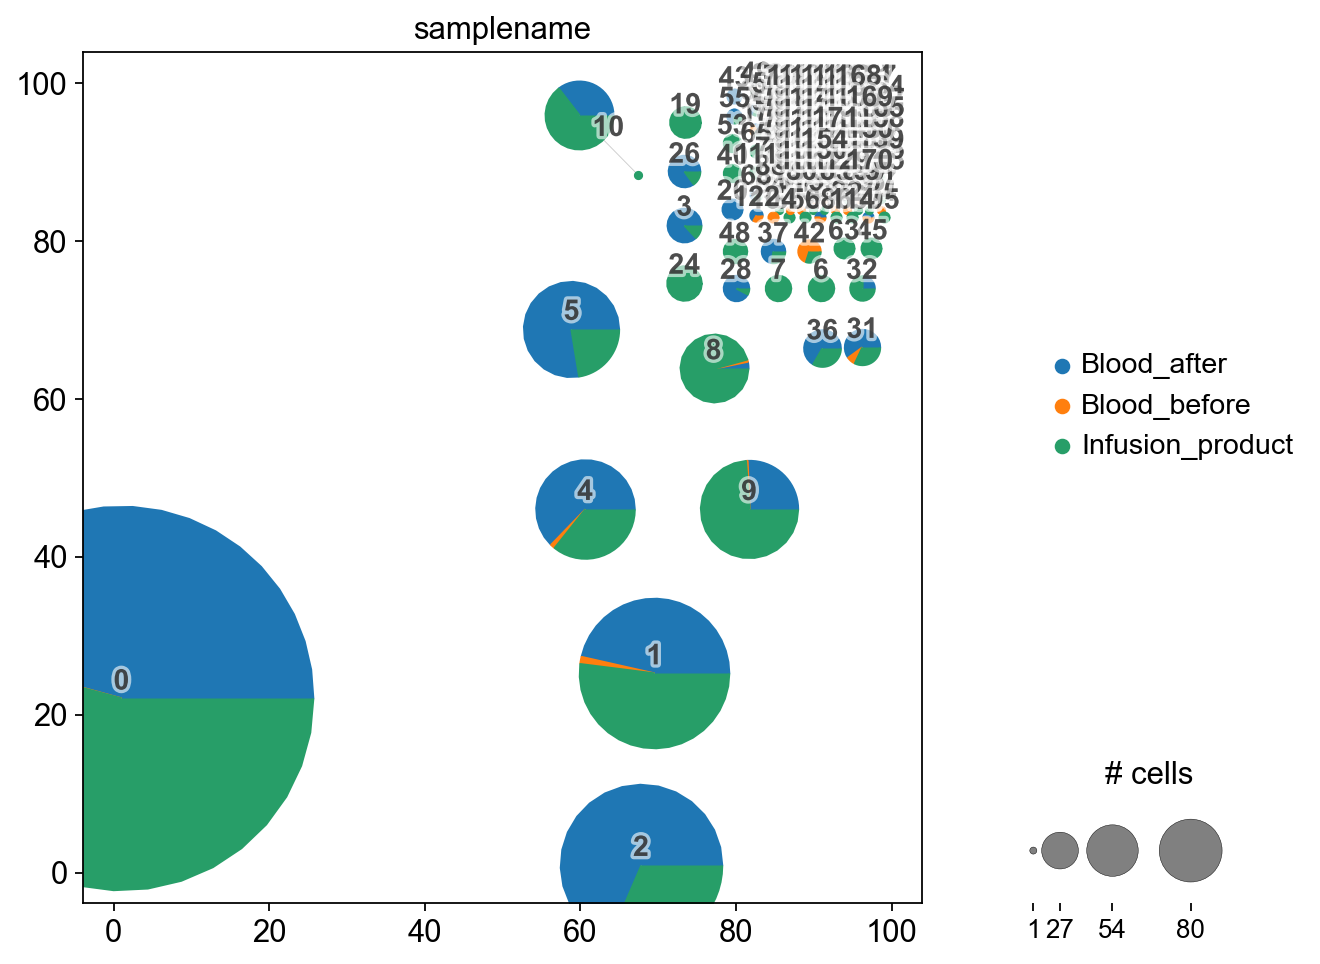

In [41]:
ir.tl.clonotype_network(adata)
ir.pl.clonotype_network(adata, color="samplename", base_size=10, panel_size=(7,7))

## Manually annotate clonotypes with secondary chains

In [42]:
additional_chain_clones=adata[np.logical_and(adata.obs.chain_pairing.isin(['extra VDJ', 'extra VJ']),
                                            adata.obs.clone_id_size>1)].obs.clone_id.unique().tolist()
#additional_chain_clones=additional_chain_clones+['2','4','5','13','14','23','49','74','184','471']

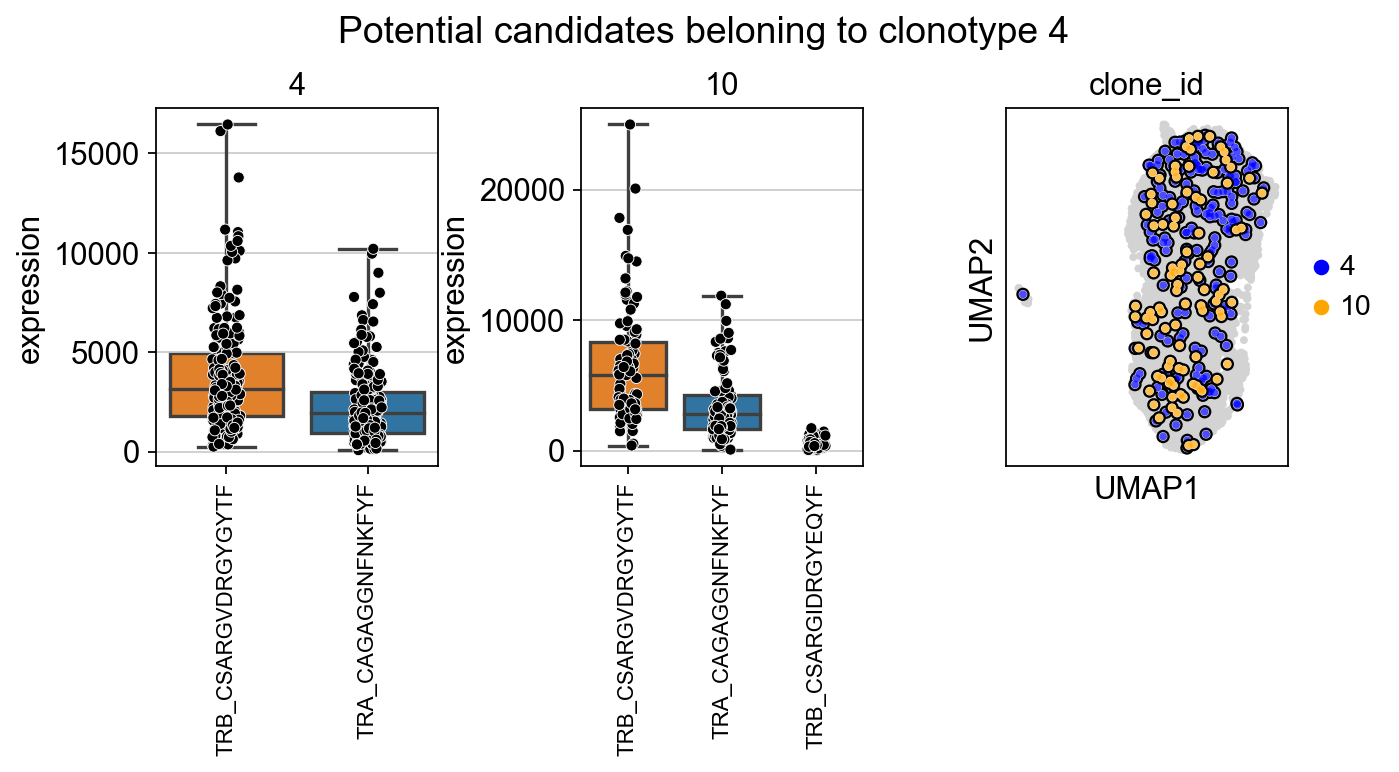

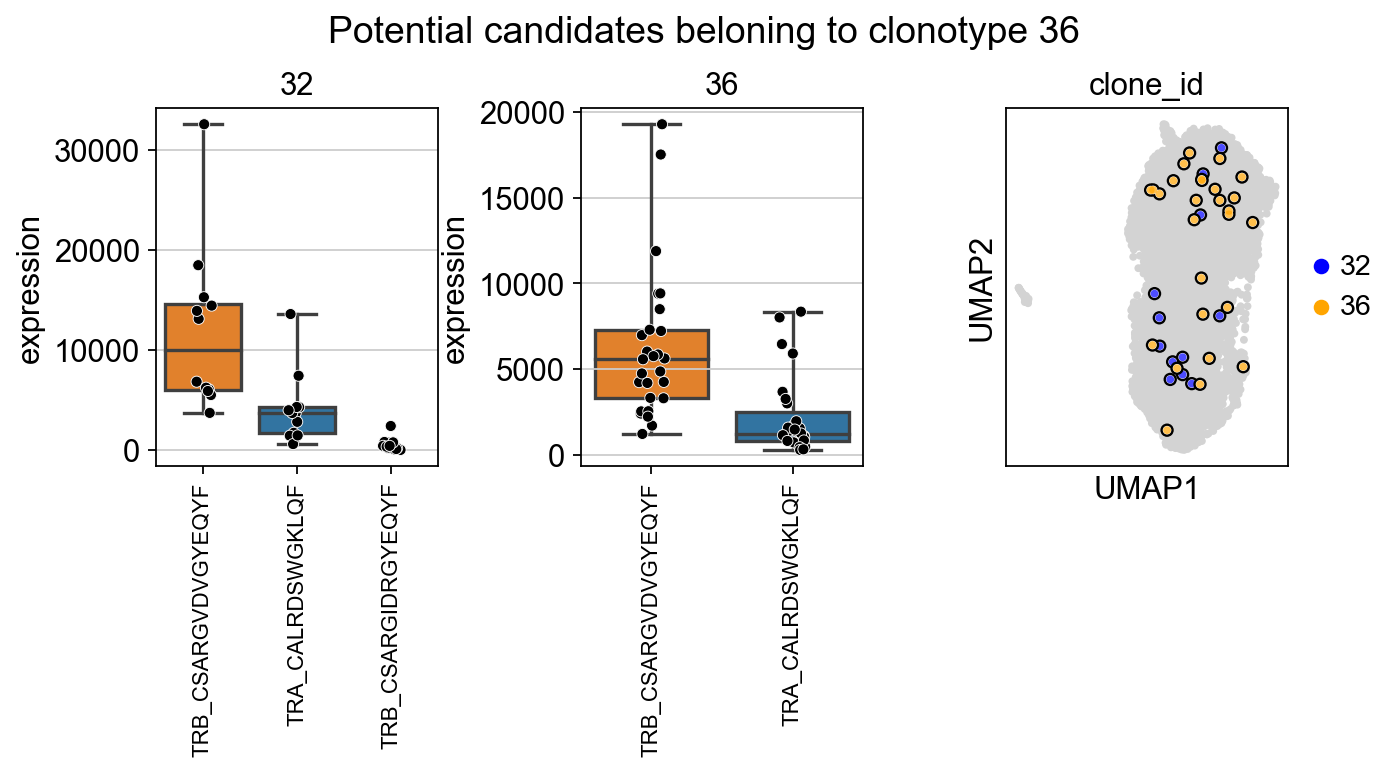

In [43]:
colors=['blue','orange']
already_plotted=[]
for j,clone in enumerate(additional_chain_clones):
    candidates=adata.obs[(adata.obs.IR_VDJ_1_junction_aa.isin(adata[adata.obs.clone_id==clone].obs.IR_VDJ_1_junction_aa.unique().tolist()))&(adata.obs.IR_VJ_1_junction_aa.isin(adata[adata.obs.clone_id==clone].obs.IR_VJ_1_junction_aa.unique().tolist()))].clone_id.unique()
    candidates=adata.obs[adata.obs.clone_id.isin(candidates)&(adata.obs.clone_id_size>3)].clone_id.unique().tolist()
    if len(candidates)!=0:
        biggest_candidate=adata[adata.obs.clone_id.isin(candidates)].obs.groupby('clone_id').agg({'clone_id_size':'mean'}).sort_values('clone_id_size', ascending=False).index[0]
        hue_order=['TRA_'+adata[adata.obs.clone_id==biggest_candidate].obs.IR_VJ_1_junction_aa.unique().tolist()[0],'TRB_'+adata[adata.obs.clone_id==biggest_candidate].obs.IR_VDJ_1_junction_aa.unique().tolist()[0]]
        if adata[adata.obs.clone_id==biggest_candidate].obs.chain_pairing[0]=='extra VJ':
            hue_order=hue_order+['TRA_'+adata[adata.obs.clone_id==biggest_candidate].obs.IR_VJ_2_junction_aa.unique().tolist()[0]]
        if adata[adata.obs.clone_id==biggest_candidate].obs.chain_pairing[0]=='extra VDJ':
            hue_order=hue_order+['TRB_'+adata[adata.obs.clonotype==biggest_candidate].obs.IR_VDJ_2_junction_aa.unique().tolist()[0]]

        clone=biggest_candidate
        candidates=adata.obs[(adata.obs.IR_VDJ_1_junction_aa.isin(adata[adata.obs.clone_id==clone].obs.IR_VDJ_1_junction_aa.unique().tolist()))&(adata.obs.IR_VJ_1_junction_aa.isin(adata[adata.obs.clone_id==clone].obs.IR_VJ_1_junction_aa.unique().tolist()))].clone_id.unique()
        candidates=adata.obs[adata.obs.clone_id.isin(candidates)&(adata.obs.clone_id_size>3)].clone_id.unique().tolist()
        ncols=len(candidates)+1
        if ((clone in already_plotted)==False) & (len(candidates)>1):
            fig,ax=plt.subplots(ncols=ncols, figsize=(len(candidates)*4,3))
            fig.tight_layout(w_pad=2, h_pad=10)
            fig.suptitle('Potential candidates beloning to clonotype '+clone, y=1.1)
            sc.pl.umap(adata, s=50, show=False, ax=ax.reshape(-1)[-1])
            for i, clonotype in enumerate(candidates):
                CDR3s=('TRB_'+adata.obs[adata.obs.clone_id==clonotype]['IR_VDJ_1_junction_aa'].astype(str)).tolist()+ \
                ('TRB_'+adata.obs[adata.obs.clone_id==clonotype]['IR_VDJ_2_junction_aa'].astype(str)).tolist()+ \
                ('TRA_'+adata.obs[adata.obs.clone_id==clonotype]['IR_VJ_1_junction_aa'].astype(str)).tolist()+ \
                ('TRA_'+adata.obs[adata.obs.clone_id==clonotype]['IR_VJ_2_junction_aa'].astype(str)).tolist()

                expression=adata.obs[adata.obs.clone_id==clonotype]['IR_VDJ_1_consensus_count'].tolist()+ \
                adata.obs[adata.obs.clone_id==clonotype]['IR_VDJ_2_consensus_count'].tolist()+ \
                adata.obs[adata.obs.clone_id==clonotype]['IR_VJ_1_consensus_count'].tolist()+ \
                adata.obs[adata.obs.clone_id==clonotype]['IR_VJ_2_consensus_count'].tolist()

                df_plot=pd.DataFrame([CDR3s,expression]).T
                df_plot.columns=['sequence','expression']
                df_plot=df_plot[~df_plot.sequence.isin(['TRA_None','TRB_None'])]
                df_plot.expression=df_plot.expression.fillna(0).astype(int)
                order=df_plot.groupby('sequence').median().sort_values('expression', ascending=False).index.tolist()
                sns.boxplot(data=df_plot, x='sequence', y='expression',ax=ax.reshape(-1)[i], hue='sequence', hue_order=hue_order,fliersize=0, whis=[0, 100], order=order, dodge=False)
                sns.stripplot(data=df_plot, x='sequence', y='expression',ax=ax.reshape(-1)[i], edgecolor='white', linewidth=0.4, order=order, color='black')
                ax.reshape(-1)[i].set_xticklabels(ax.reshape(-1)[i].get_xticklabels(),rotation=90, size=10)
                ax.reshape(-1)[i].set_title(clonotype)
                ax.reshape(-1)[i].set_xlabel('')
                ax.reshape(-1)[i].get_legend().remove()
                sc.pl.umap(adata[adata.obs.clone_id==clonotype].copy(), color='clone_id', groups=clonotype, s=50, show=False, palette=[colors[i]], ax=ax.reshape(-1)[-1], add_outline=True)
            plt.savefig('./clonotype_annotation/clonotypes_candidates_belonging_to_'+clone+'.pdf', bbox_inches='tight')
            plt.show()
    already_plotted=already_plotted+[clone]

In [44]:
adata.obs['clonotype_group']=adata.obs['clone_id']
adata.obs['clonotype_group_size']=adata.obs['clone_id_size']

In [45]:
adata.obs['clonotype_group'][adata.obs.clone_id.isin(['4','10'])]='4'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='4']=sum(adata.obs[adata.obs.clone_id.isin(['4','10'])].groupby('clone_id')['clone_id_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clone_id.isin(['32','36'])]='32'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='32']=sum(adata.obs[adata.obs.clone_id.isin(['32','36'])].groupby('clone_id')['clone_id_size'].agg('first').fillna(0).unique().tolist())

In [46]:
adata.obs['clonotype_old']=adata.obs['clone_id']
adata.obs['clonotype_size_old']=adata.obs['clone_id_size']
adata.obs['clone_id']=adata.obs['clonotype_group']
adata.obs['clone_id_size']=adata.obs['clonotype_group_size']

In [47]:
adata_infusion = adata[adata.obs['samplename']=='Infusion_product',:]
adata_blood_before = adata[adata.obs['samplename']=='Blood_before',:]
adata_blood_after = adata[adata.obs['samplename']=='Blood_after',:]

single_donor_adatas=[adata_infusion,adata_blood_before,adata_blood_after]
single_donor_adatas_names=['Infusion_product','Blood_before','Blood_after']

<AxesSubplot:>

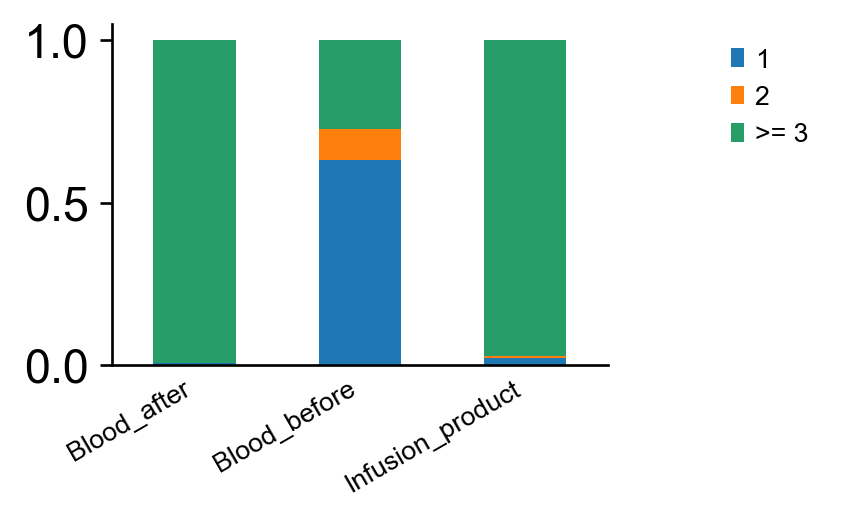

In [48]:
ir.tl.clonal_expansion(adata, clip_at=3)
#adata.obs['clonal_expansion']=adata.obs['clonal_expansion'].astype(int)
ir.pl.clonal_expansion(adata, "samplename")

In [49]:
clonotypes_re_expression=['2','4','5','13','14','23','49','74','184','471']

In [50]:
clonotypes=adata[np.logical_and(np.logical_and(adata.obs.clone_id.isin(single_donor_adatas[0].obs.clone_id),
                                    adata.obs.clone_id.isin(single_donor_adatas[1].obs.clone_id)),
                     adata.obs.clone_id.isin(single_donor_adatas[2].obs.clone_id))].obs['clone_id'].unique()

... storing 'clonal_expansion' as categorical


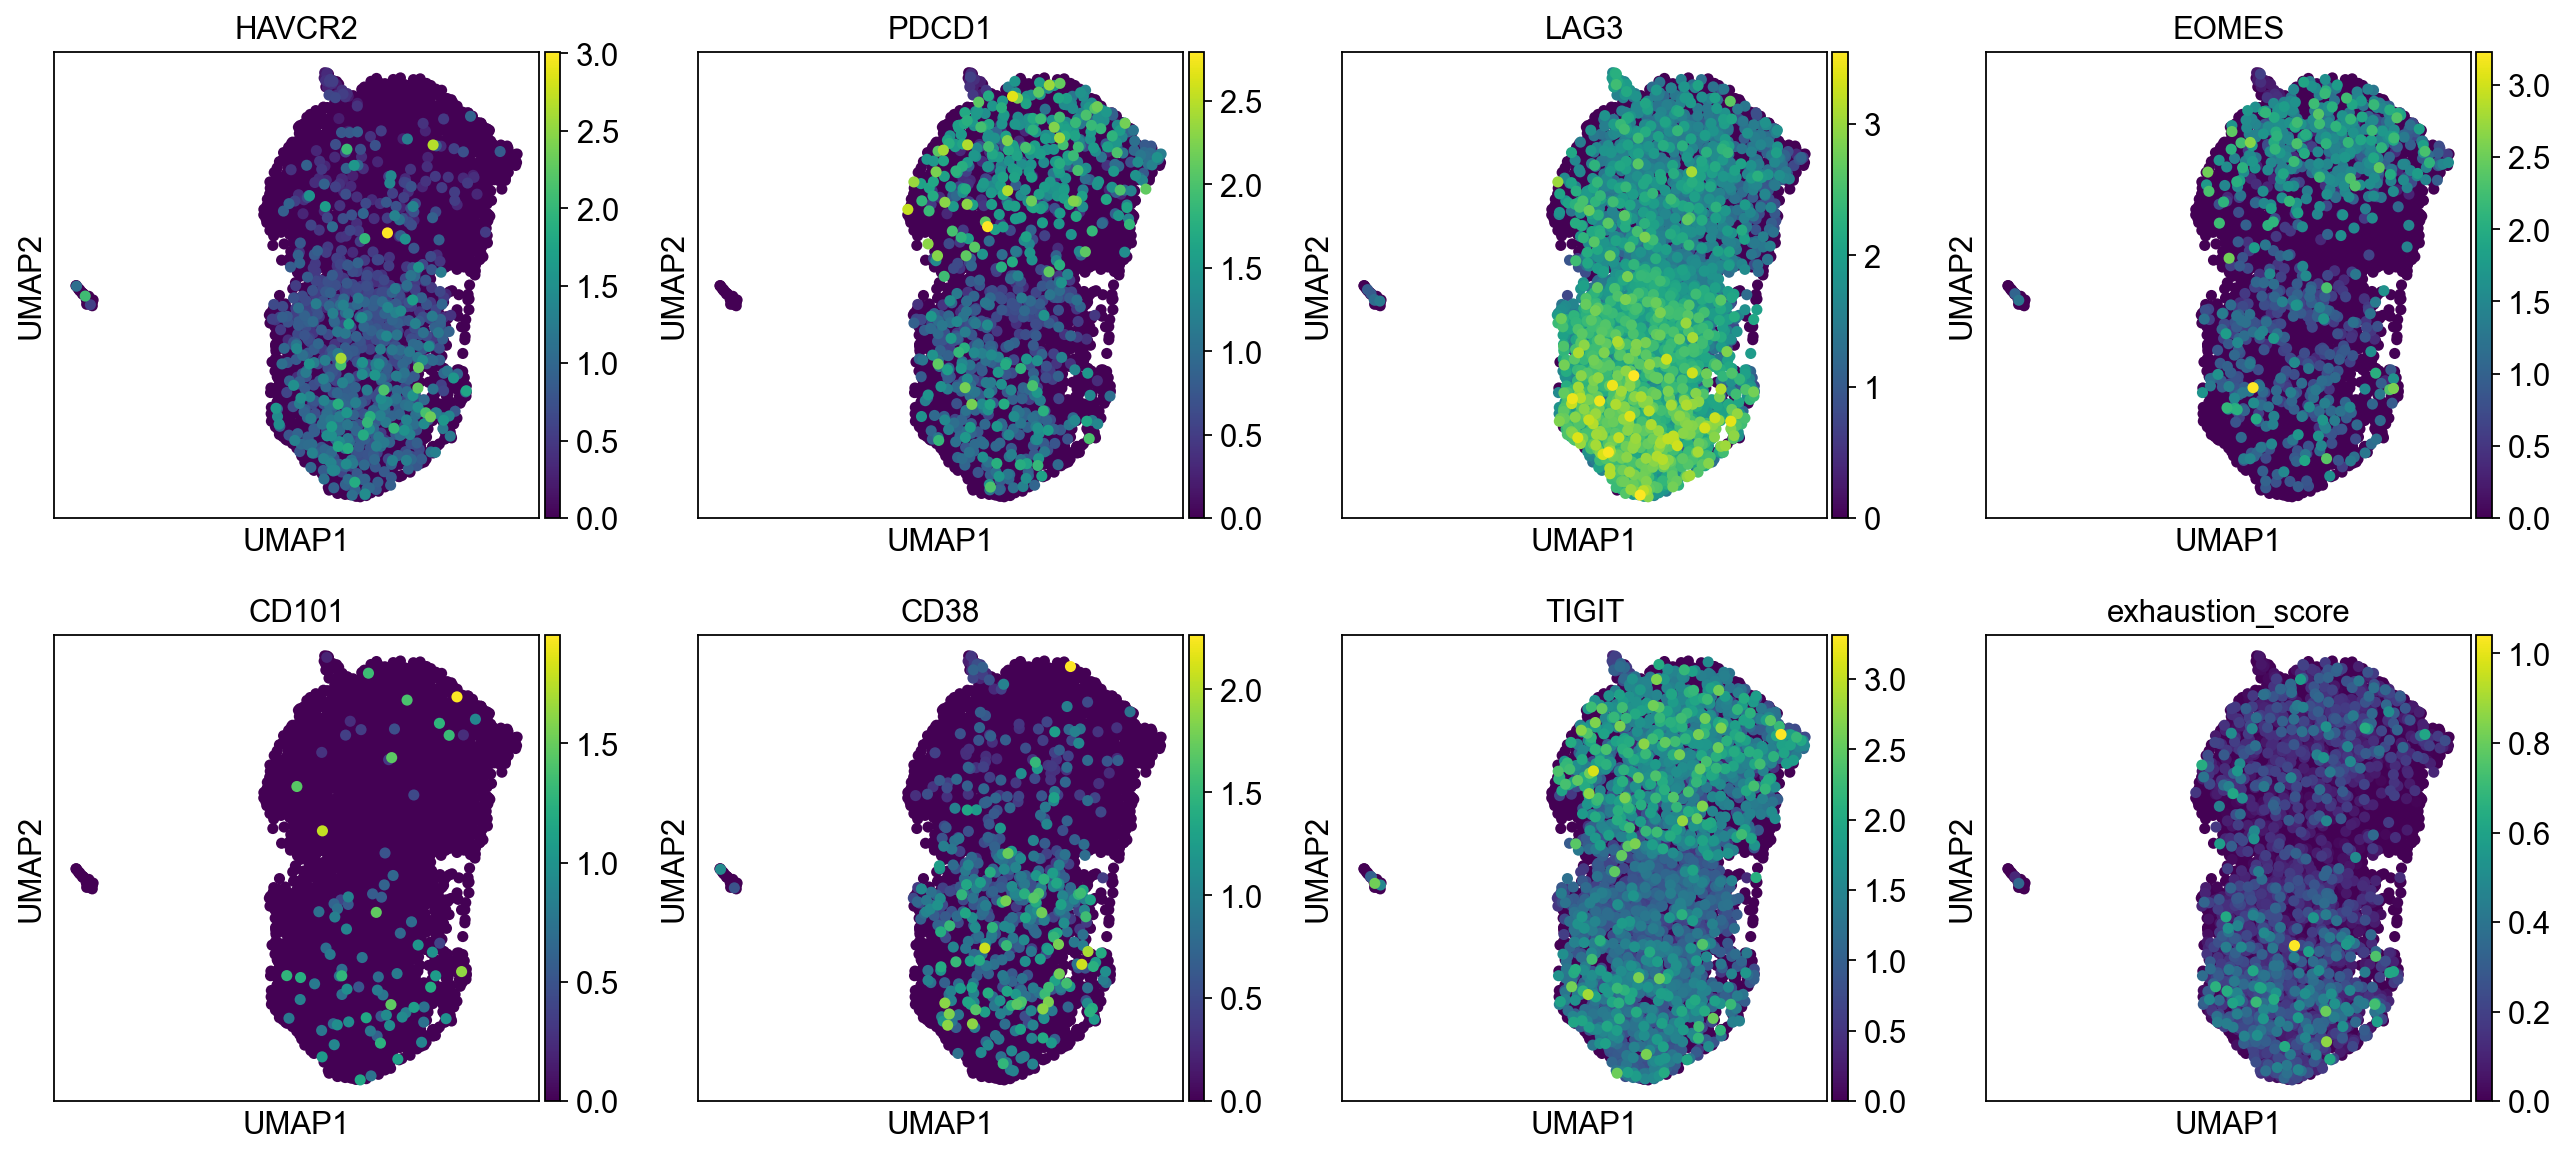

In [51]:
sc.pl.umap(adata, color=['HAVCR2','PDCD1','LAG3','EOMES','CD101','CD38','TIGIT','exhaustion_score'],vmin=0,s=100)

In [52]:
df=adata.obs

In [53]:
df['PD1']=[x[0] for x in adata.raw[:,'PDCD1'].X.todense().tolist()]
df['CD39']=[x[0] for x in adata.raw[:,'ENTPD1'].X.todense().tolist()]
df['CX3CR1']=[x[0] for x in adata.raw[:,'CX3CR1'].X.todense().tolist()]
df['NKG2D']=[x[0] for x in adata.raw[:,'KLRK1'].X.todense().tolist()]
df['GZMK']=[x[0] for x in adata.raw[:,'GZMK'].X.todense().tolist()]
df['PRF1']=[x[0] for x in adata.raw[:,'PRF1'].X.todense().tolist()]

In [54]:
#adata.obs['PD1']=[x[0] for x in adata.raw[:,'PDCD1'].X.todense().tolist()]
#adata.obs['CD39']=[x[0] for x in adata.raw[:,'ENTPD1'].X.todense().tolist()]
#adata.obs['CX3CR1']=[x[0] for x in adata.raw[:,'CX3CR1'].X.todense().tolist()]
#adata.obs['NKG2D']=[x[0] for x in adata.raw[:,'KLRK1'].X.todense().tolist()]
#adata.obs['GZMK']=[x[0] for x in adata.raw[:,'GZMK'].X.todense().tolist()]
#adata.obs['PRF1']=[x[0] for x in adata.raw[:,'PRF1'].X.todense().tolist()]

In [55]:
df=df.sort_values('clone_id_size',ascending=False)
df_plot=df[df.clone_id_size>2]
df_plot['size_infusion']=0
df_plot['size_blood_before']=0
df_plot['size_blood_after']=0

df_plot['frq_PD1_infusion']=0
df_plot['frq_PD1_blood_before']=0
df_plot['frq_PD1_blood_after']=0

In [56]:
for samplename in adata.obs.samplename.unique().tolist():
    adata.obs['size_'+samplename]=0
    adata.obs['frq_PD1_'+samplename]=0
    adata.obs['PD1_'+samplename]=0
    adata.obs['PDCD1_SP_'+samplename]=0
    adata.obs['activation_score_'+samplename]=0
    adata.obs['predysfunctional_score_'+samplename]=0
    adata.obs['dysfunctional_score_'+samplename]=0
    adata.obs['cytotox_score_'+samplename]=0
    adata.obs['cytotoxic_activation_'+samplename]=0
    adata.obs['naive_like_state_'+samplename]=0
    adata.obs['cytokine_activation_'+samplename]=0

for i, clonotype in enumerate(adata.obs.clone_id.unique()):
    for samplename in adata.obs.samplename.unique().tolist():
        adata.obs['size_'+samplename][adata.obs.clone_id==clonotype]=adata.obs[adata.obs.clone_id==clonotype].samplename.value_counts()[samplename]
        
        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            adata.obs['frq_PD1_'+samplename][adata.obs.clone_id==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100
            
        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            adata.obs['PD1_'+samplename][adata.obs.clone_id==clonotype]=df_temp.PD1.mean()
            
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.PDCD1_SP, columns=['PDCD1_SP'])
        if df_temp.shape[0]!=0:
            adata.obs['PDCD1_SP_'+samplename][adata.obs.clone_id==clonotype]=df_temp.PDCD1_SP.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.activation_score, columns=['activation_score'])
        if df_temp.shape[0]!=0:
            adata.obs['activation_score_'+samplename][adata.obs.clone_id==clonotype]=df_temp.activation_score.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.predysfunctional_state, columns=['predysfunctional_state'])
        if df_temp.shape[0]!=0:
            adata.obs['predysfunctional_score_'+samplename][adata.obs.clone_id==clonotype]=df_temp.predysfunctional_state.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.dysfunctional_state, columns=['dysfunctional_state'])
        if df_temp.shape[0]!=0:
            adata.obs['dysfunctional_score_'+samplename][adata.obs.clone_id==clonotype]=df_temp.dysfunctional_state.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.cytotoxic_state, columns=['cytotoxic_state'])
        if df_temp.shape[0]!=0:
            adata.obs['cytotox_score_'+samplename][adata.obs.clone_id==clonotype]=df_temp.cytotoxic_state.mean()
            
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.cytotoxic_activation, columns=['cytotoxic_activation'])
        if df_temp.shape[0]!=0:
            adata.obs['cytotoxic_activation_'+samplename][adata.obs.clone_id==clonotype]=df_temp.cytotoxic_activation.mean()
            
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.naive_like_state, columns=['naive_like_state'])
        if df_temp.shape[0]!=0:
            adata.obs['naive_like_state_'+samplename][adata.obs.clone_id==clonotype]=df_temp.naive_like_state.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename==samplename)].obs.cytokine_activation, columns=['cytokine_activation'])
        if df_temp.shape[0]!=0:
            adata.obs['cytokine_activation_'+samplename][adata.obs.clone_id==clonotype]=df_temp.cytokine_activation.mean()
   
    print(str(np.round(((i+1)/len(adata.obs.clone_id.unique()))*100,1))+"%", end="\r", flush=True)

In [57]:
calculate_size = True

In [58]:
if calculate_size == True:
    for i, clonotype in enumerate(df_plot.clone_id.unique()):
        df_plot['size_infusion'][df_plot.clone_id==clonotype]=df_plot[df_plot.clone_id==clonotype].samplename.value_counts()['Infusion_product']
        df_plot['size_blood_before'][df_plot.clone_id==clonotype]=df_plot[df_plot.clone_id==clonotype].samplename.value_counts()['Blood_before']
        df_plot['size_blood_after'][df_plot.clone_id==clonotype]=df_plot[df_plot.clone_id==clonotype].samplename.value_counts()['Blood_after']

        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename=='Infusion_product'),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            df_plot['frq_PD1_infusion'][df_plot.clone_id==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100

        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename=='Blood_before'),'PDCD1'].X], columns=['PD1'])    
        if df_temp.shape[0]!=0:
            df_plot['frq_PD1_blood_before'][df_plot.clone_id==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100

        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clone_id==clonotype,adata.obs.samplename=='Blood_after'),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            df_plot['frq_PD1_blood_after'][df_plot.clone_id==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100

        print(str(np.round(((i+1)/len(df_plot.clone_id.unique()))*100,1))+"%", end="\r", flush=True)
    df_plot.to_csv('df_plot.csv')
if calculate_size == False:
    df_plot=pd.read_csv('df_plot.csv', index_col=0)

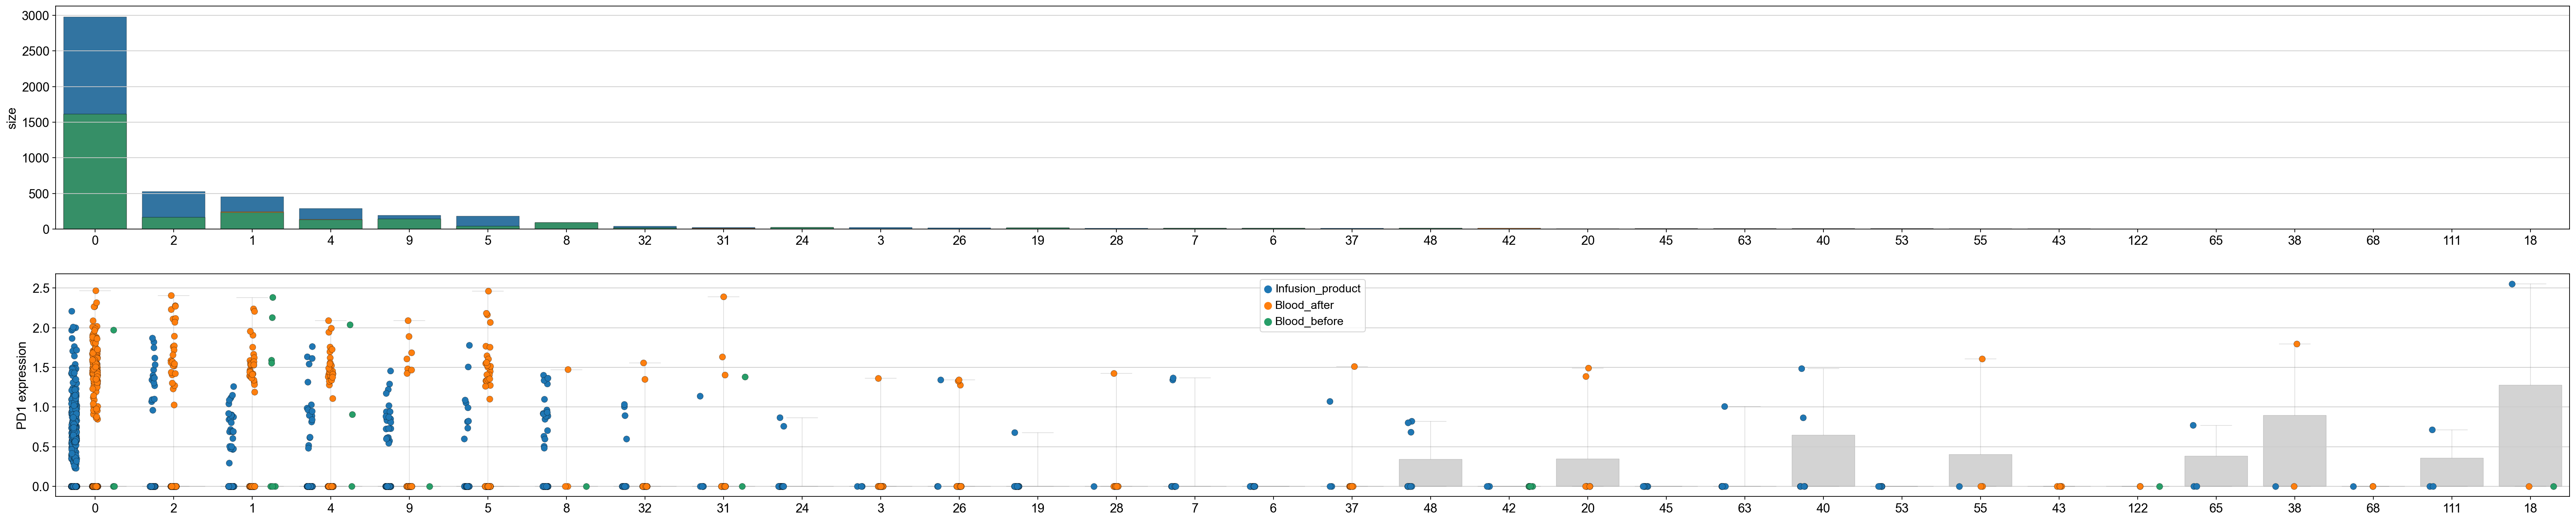

In [59]:
fig,ax=plt.subplots(nrows=2, figsize=(50,10))

order=df_plot.sort_values('clone_id_size',ascending=False).clone_id.unique().tolist()

x=df_plot.clone_id.tolist()
y1=df_plot.size_blood_after+df_plot.size_blood_before+df_plot.size_infusion
y2=df_plot.size_blood_before+df_plot.size_infusion
y3=df_plot.size_infusion
hue=df_plot.samplename
sns.barplot(x=x,y=y1, color='#1f77b4', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y2, color='#ff7f0e', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y3, color='#279e68', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
ax[0].set_ylabel('size')

x=df_plot.clone_id.tolist()
y=df_plot.PD1.tolist()
hue=df_plot.samplename.tolist()
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[1], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[1], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True)
ax[1].set_ylabel('PD1 expression')

fig.savefig('./figures/dotplot.pdf', dpi=300)

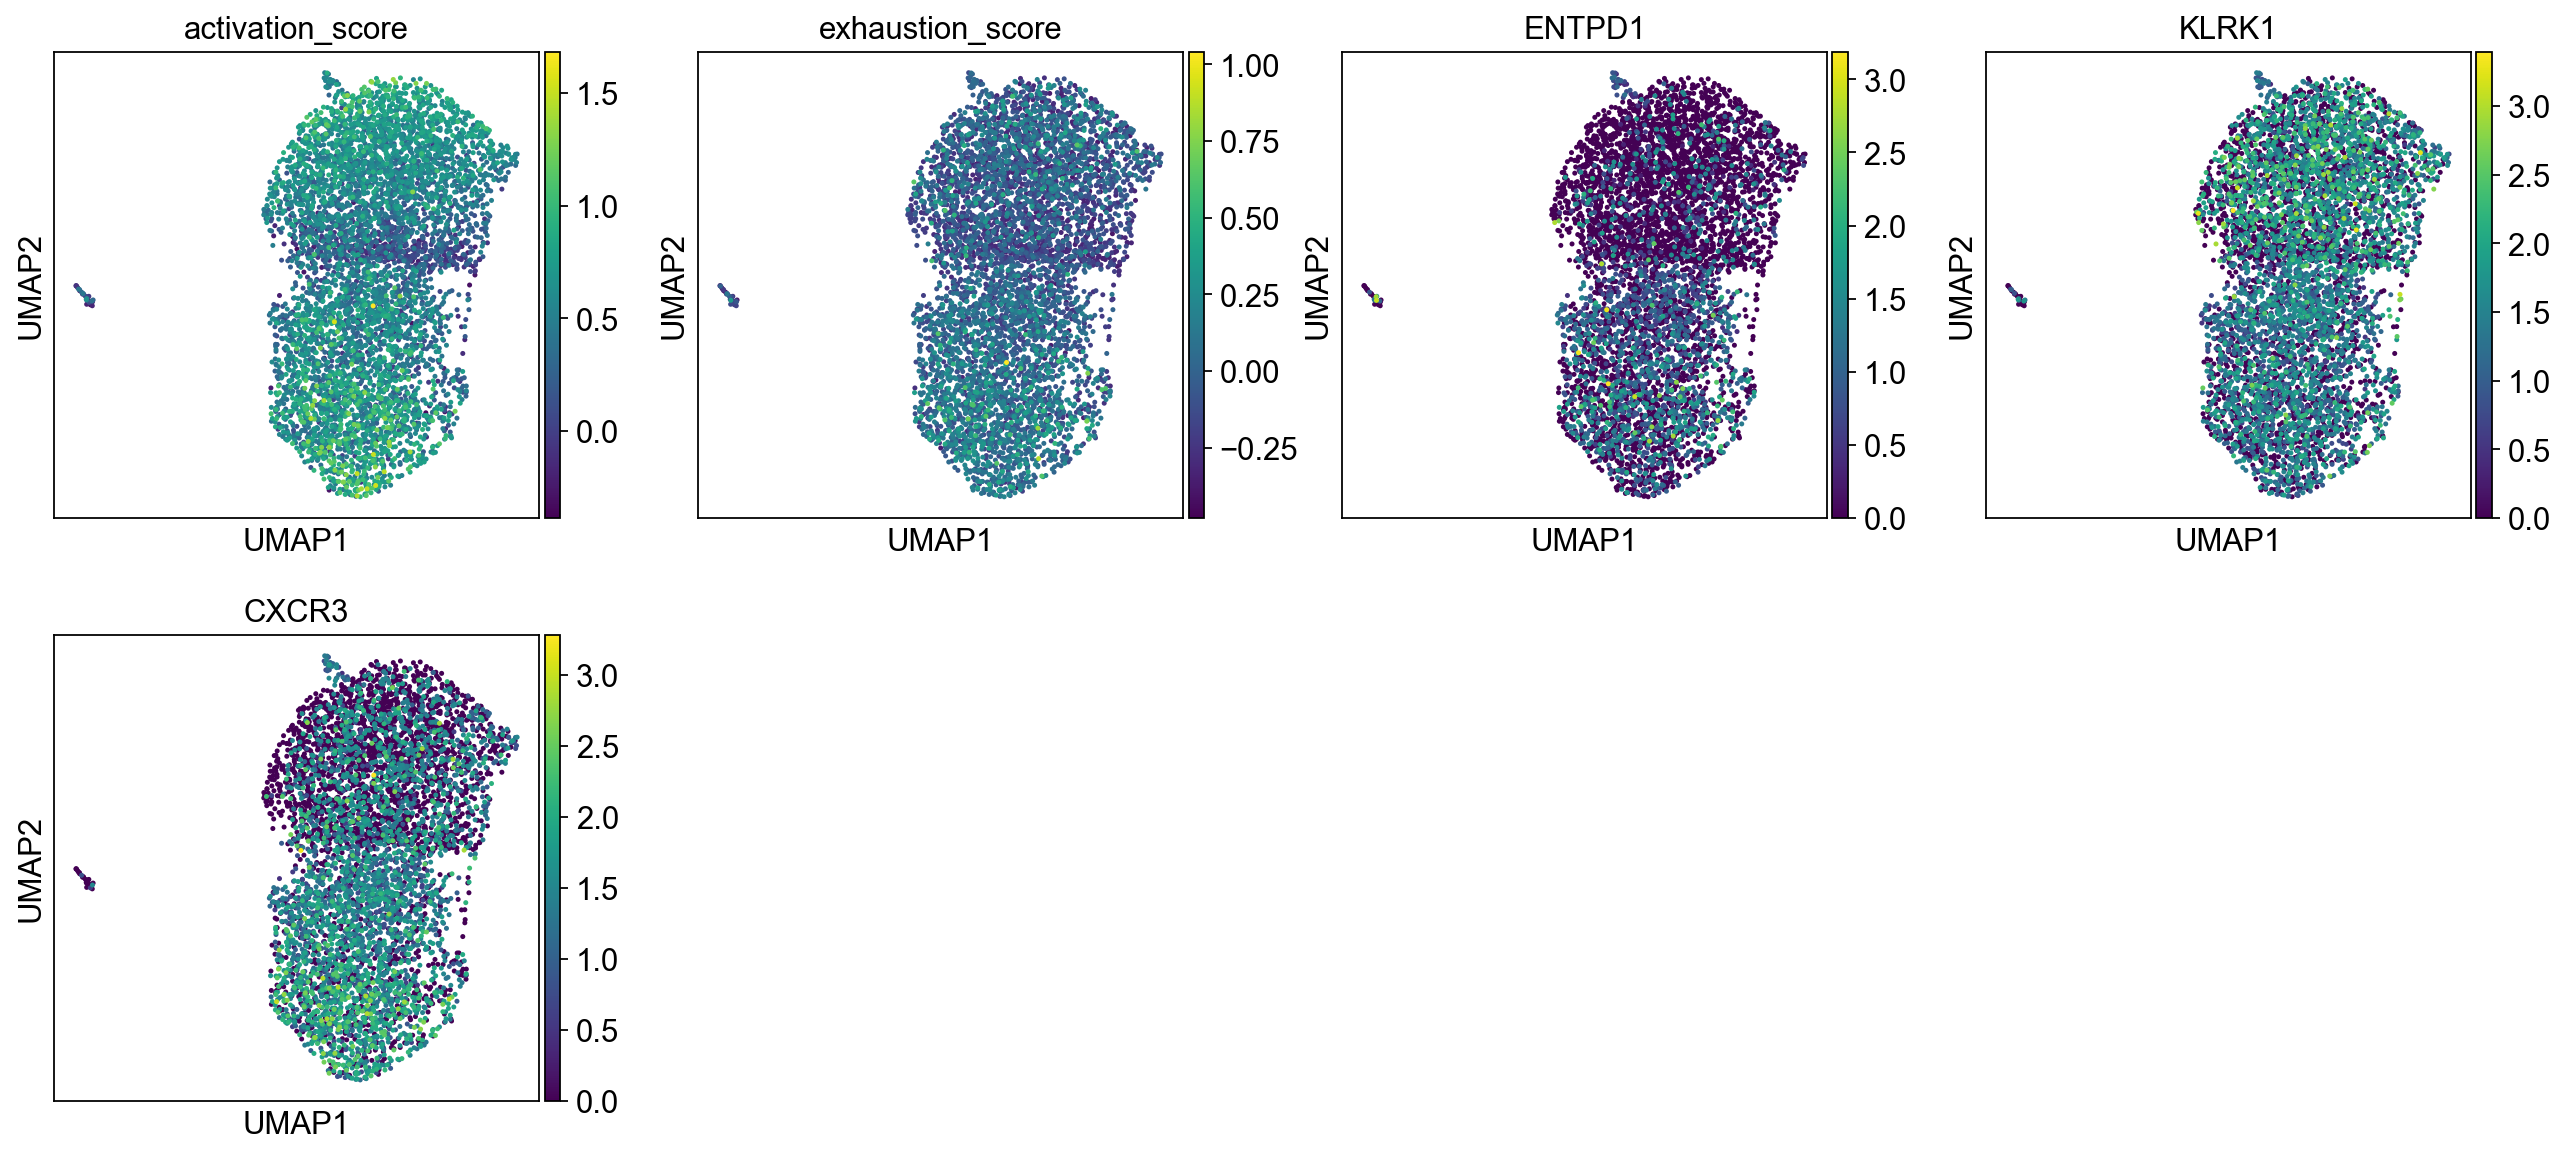

In [60]:
sc.pl.umap(adata, color=['activation_score','exhaustion_score','ENTPD1','KLRK1','CXCR3'])

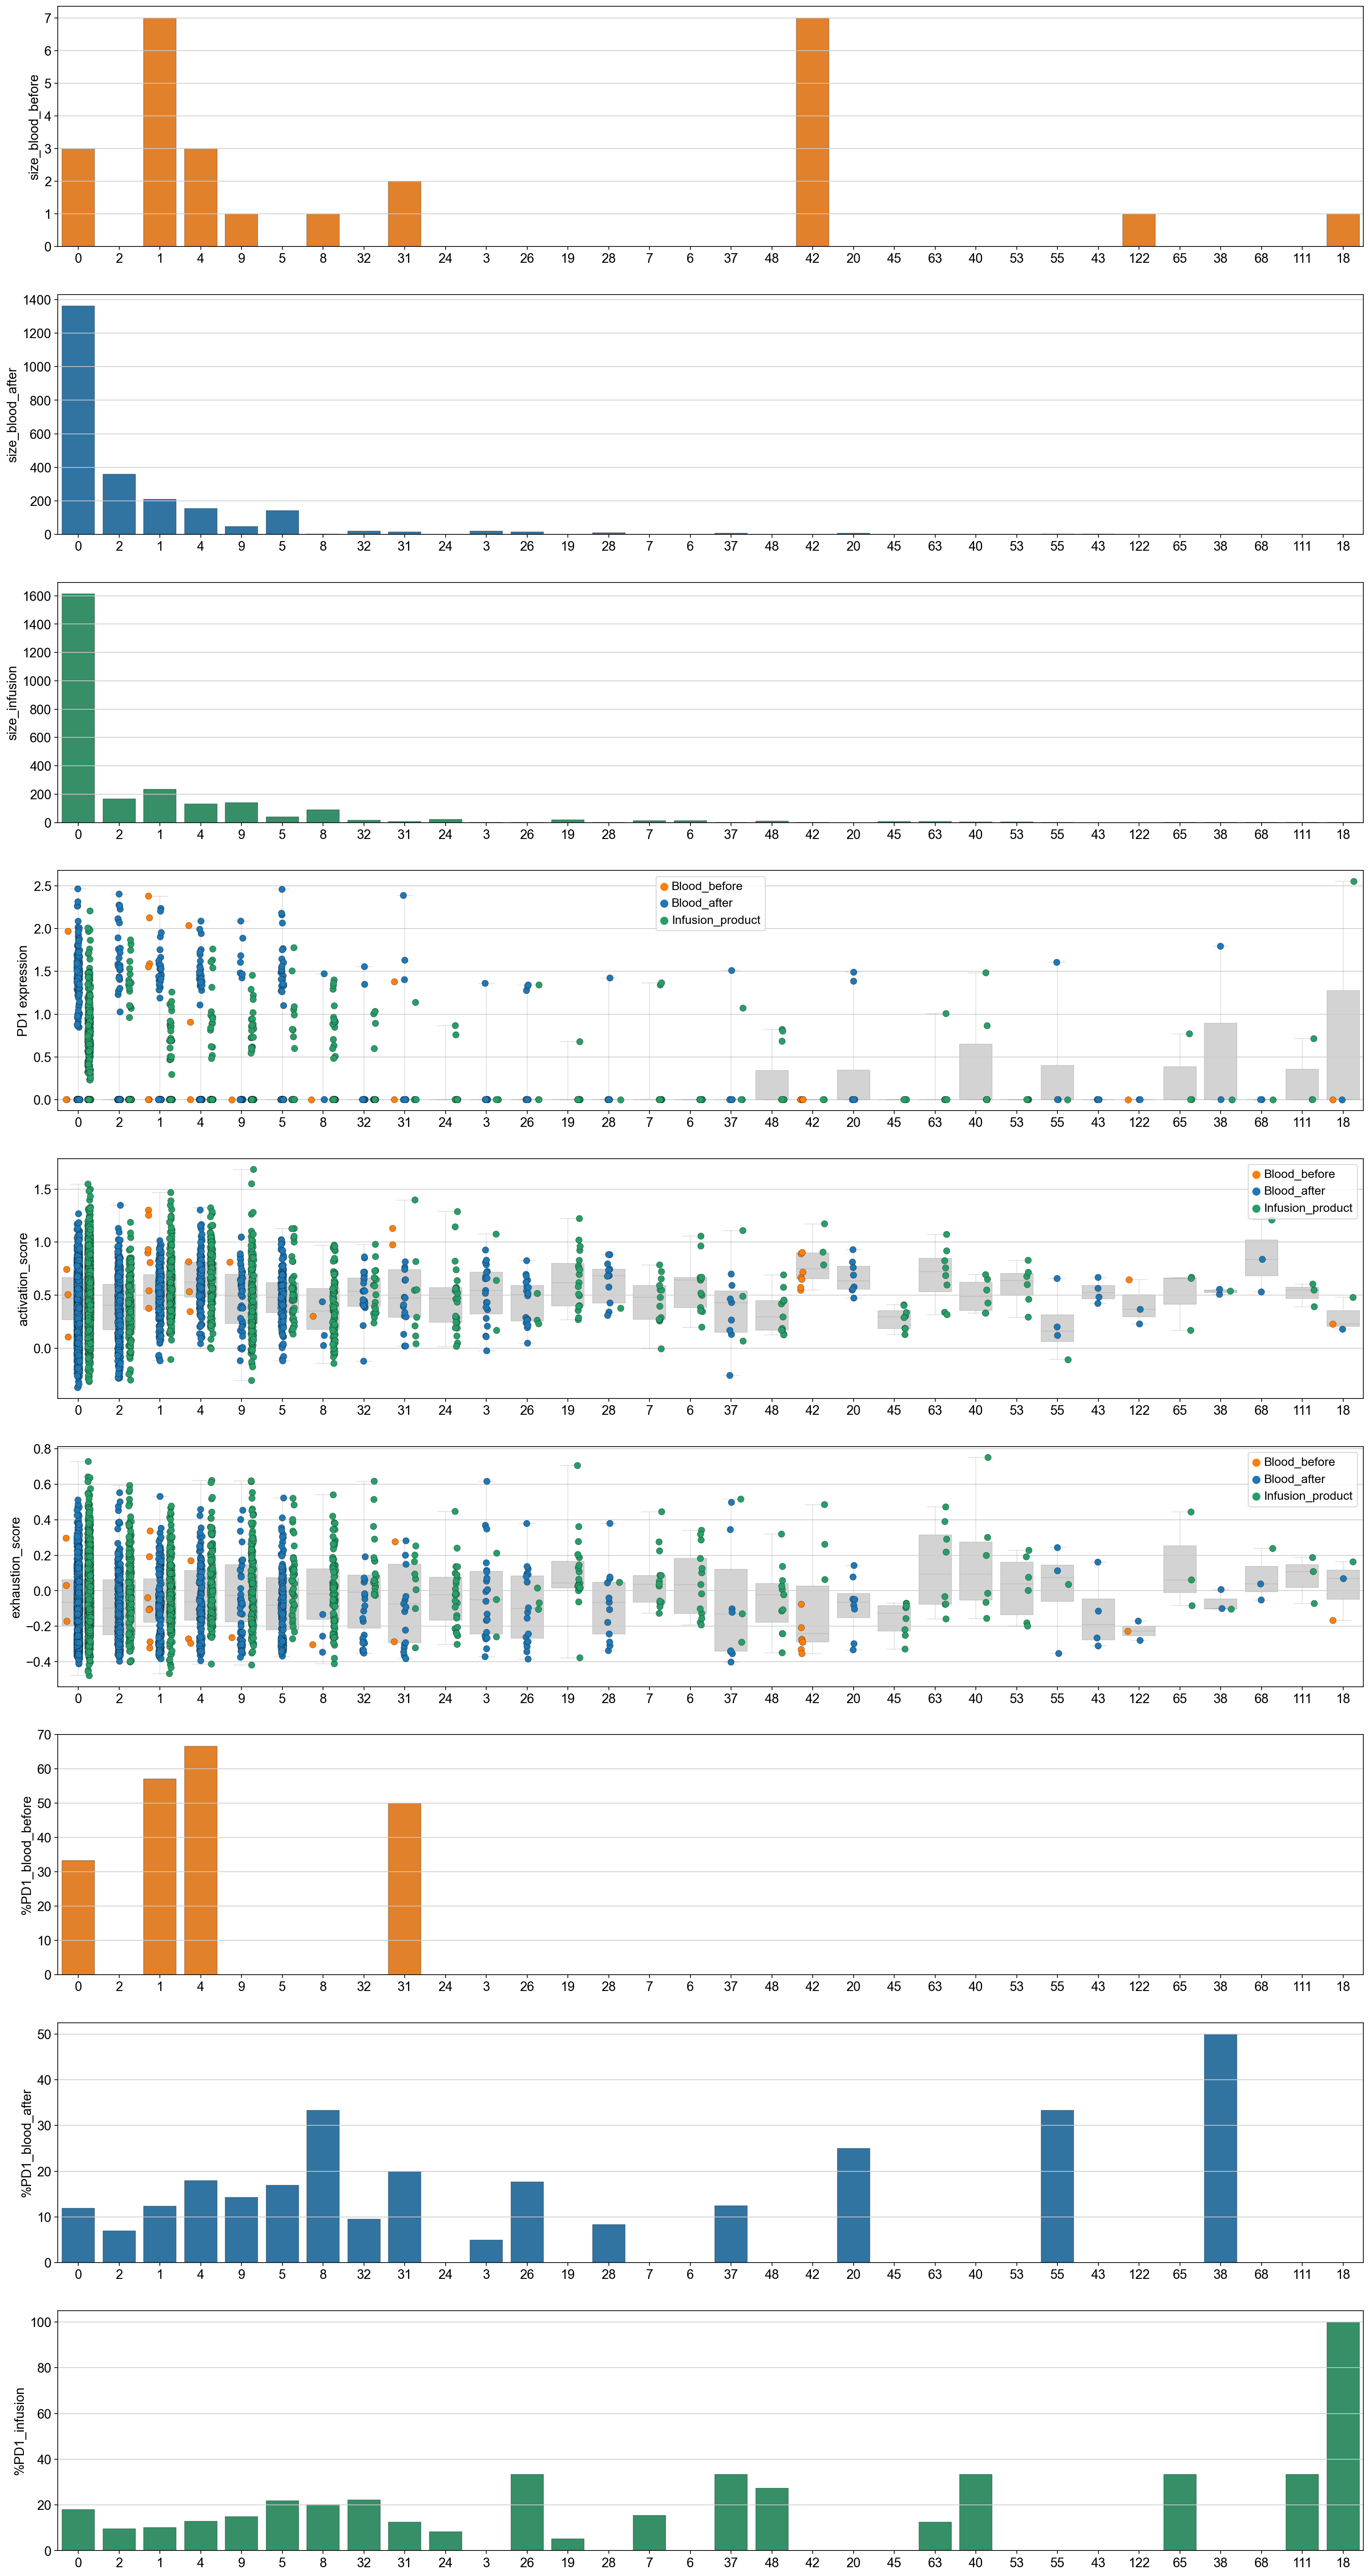

In [61]:
fig,ax=plt.subplots(nrows=9, figsize=(25,50))
order=df_plot.sort_values('clone_id_size',ascending=False).clone_id.unique().tolist()

x=df_plot.clone_id.tolist()
y1=df_plot.size_blood_after
y2=df_plot.size_blood_before
y3=df_plot.size_infusion
hue=df_plot.samplename.tolist()
sns.barplot(x=x,y=y1, color='#1f77b4', ax=ax[1], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y2, color='#ff7f0e', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y3, color='#279e68', ax=ax[2], order=order, edgecolor='black', linewidth=0.2)
ax[1].set_ylabel('size_blood_after')
ax[0].set_ylabel('size_blood_before')
ax[2].set_ylabel('size_infusion')

y=df_plot.PD1.tolist()
hue_order=['Blood_before','Blood_after','Infusion_product']
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[3], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[3], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True,
              palette=['#ff7f0e','#1f77b4','#279e68'], hue_order=hue_order)
ax[3].set_ylabel('PD1 expression')

y=df_plot.activation_score.tolist()
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[4], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[4], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True, 
              palette=['#ff7f0e','#1f77b4','#279e68'], hue_order=hue_order)
ax[4].set_ylabel('activation_score')

y=df_plot.exhaustion_score.tolist()
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[5], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[5], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True, 
              palette=['#ff7f0e','#1f77b4','#279e68'], hue_order=hue_order)
ax[5].set_ylabel('exhaustion_score')

y4=df_plot.frq_PD1_blood_after
y5=df_plot.frq_PD1_blood_before
y6=df_plot.frq_PD1_infusion
sns.barplot(x=x,y=y4, color='#1f77b4', ax=ax[7], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y5, color='#ff7f0e', ax=ax[6], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y6, color='#279e68', ax=ax[8], order=order, edgecolor='black', linewidth=0.2)
ax[7].set_ylabel('%PD1_blood_after')
ax[6].set_ylabel('%PD1_blood_before')
ax[8].set_ylabel('%PD1_infusion')

fig.savefig('./figures/dotplot_single_size_PD1_activation.pdf', dpi=300)

In [66]:
adata.obs=adata.obs.loc[:,~adata.obs.columns.isin(['PD1','CD39','CX3CR1','NKG2D','GZMK','PRF1'])].copy()

In [67]:
adata.write('adata_figures.h5ad')